<a href="https://colab.research.google.com/github/eas342/nircam_science_meeting_jwebbinar/blob/main/jwst_imaging_mode_nc_science_meeting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a id='top'></a>
# Imaging Mode Data Calibration: Part 1 - Ramps to Slopes
---
**Author**: Bryan Hilbert (hilbert@stsci.edu)| **Latest Update**: 20 May 2021

Everett Schlawin re-arranged mid-December, 2021 to make it much shorter

<div class="alert alert-block alert-warning">
    <h3><u><b>Part 1 Notebook Goals</b></u></h3>
    <ul>Working with the Stage 1 Calibration Pipeline, we will:</ul>    
<ul>
    <li>Look at one way to call the pipeline</li>
</ul>
</div>

## Table of Contents

Click the top left icon that looks like a bulleted list for a table of contents to browse this in Google Colab


If you are using a Jupyter notebook, you can use the table of contents below
* [Introduction](#intro)
* [Pipeline Resources and Documentation](#resources)
   * [Installation](#installation)
   * [Reference Files](#reference_files)
* [Imports](#imports)
* [Convenience Functions](#convenience_functions)
* [Download Data](#download_data)
* [Methods for calling steps/pipelines](#calling_methods)
* [Parameter reference files](#parameter_reffiles)
* [calwebb_detector1 - Ramps to slopes](#detector1) 
   * [Run the entire pipeline](#detector1_at_once)
       * [run() method](#run_method)
       * [call() method](#call_method)
       * [command line](#command_line)
       * [Exercise 1](#exercise1)
   * [Run the individual pipeline steps](#detector1_step_by_step)
       * [The `Data Quality Initialization` step](#dq_init)
       * [The `Saturation Flagging` step](#saturation)
       * [The `Superbias Subtraction` step](#superbias)
       * [The `Reference Pixel Subtraction` step](#refpix)
           * [Exercise 2](#exercise2)
       * [The `Linearity Correction` step](#linearity)
       * [The `Persistence Correction` step](#persistence)
       * [The `Dark Current Subtraction` step](#dc)
       * [The `Cosmic Ray Flagging` step](#jump)
       * [The `Ramp_Fitting` step](#ramp_fitting)
* [Bonus Topic: Logging](#logging)
* [Exercise solutions](#exercise_solutions)
    * [Exercise 1 solution](#exercise1_solution)
    * [Exercise 2 solution](#exercise2_solution)

<a id='intro'></a>
## Introduction

This notebook covers part 1 of the imaging mode data calibration module. In this notebook we'll review Stage 1 of the JWST calibration pipeline, also known as *calwebb_detector1*. 

The [Stage 1 pipeline](https://jwst-pipeline.readthedocs.io/en/stable/jwst/pipeline/calwebb_detector1.html#calwebb-detector1) applies basic detector-level corrections to all exposure types (imaging, spectroscopic, coronagraphic, etc.). It is applied to one exposure at a time, beginning with an uncalibrated multiaccum ramp (*_uncal.fits file*). It is sometimes referred to as “ramps-to-slopes” processing. 

Each input raw data file is composed of one or more ramps (integrations) containing increasing count values from the non-destructive detector readouts. For details on multiaccum files and data collection, see the JDox page on [how up-the-ramp readouts work](https://jwst-docs.stsci.edu/understanding-exposure-times#UnderstandingExposureTimes-uptherampHowup-the-rampreadoutswork).

The output is a corrected but uncalibrated countrate or slope image (*_rate.fits and _rateints.fits file*). In this case, "calibrated/uncalibrated" is based on the units of the data. Any data in units of DN or DN/sec are considered uncalibrated. After the flux calibration step of the Stage 2 pipeline is run and the data units become physical units (e.g. MJy/str), then the data are said to be calibrated.

To illustrate how the steps of the pipeline change the input data, we will download a sample file and run it through the pipeline, examining the results at several places along the way.

All JWST data, regardless of instrument and observing mode, are processed through the Stage 1 pipeline. The corrections performed are the same across all near-IR instruments. There are several additional MIRI-specific steps. For the purposes of this notebook, our example file will be NIRCam data. We will also provide an example MIRI file that can be used in a separate exercise.

<a id='resources'></a>
## Pipeline Resources and Documentation

There are several different places to find information on installing and running the pipeline. This notebook will summarize each Stage 1 pipeline step. To find more in-depth instructions use the links below.

* [JWST Documentation (JDox) for the Stage 1 pipeline](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline-overview/stages-of-jwst-data-processing/calwebb_detector1) including short a short summary of what each step does.

* [High-level description of all pipeline stages and steps](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/main.html) from the pipeline software documentation website.

* [`jwst` package documentation](https://jwst-pipeline.readthedocs.io/en/latest/jwst/introduction.html) including how to run the pipeline, input/output files, etc.

* [`jwst` package GitHub repository, with installation instructions](https://github.com/spacetelescope/jwst/blob/master/README.md)

* [**Help Desk**](https://stsci.service-now.com/jwst?id=sc_cat_item&sys_id=27a8af2fdbf2220033b55dd5ce9619cd&sysparm_category=e15706fc0a0a0aa7007fc21e1ab70c2f): **If you have any questions or problems regarding the pipeline, submit a ticket to the Help Desk**

<a id='installation'></a>
### Installation

<div class="alert alert-block alert-info">
    During the JWebbinar, we will be working in a pre-existing environment where the <b>jwst</b> package has already been installed, so you won't need to install it yourself.
</div>

<div class="alert alert-block alert-warning">
If you wish to run this notebook outside of this JWebbinar, you will have to first install the <b>jwst</b> package.<br>

For more detailed instructions on the various ways to install the package, see the [installation instructions](https://github.com/spacetelescope/jwst/blob/master/README.md) on GitHub.

The easiest way to install the pipeline is via `pip`. Below we show how to create a new conda environment, activate that environment, and then install the latest released version of the pipeline. You can name your environment anything you like. In the lines below, replace `<env_name>` with your chosen environment name.

>`conda create -n <env_name> python`<br>
>`conda activate <env_name>`<br>
>`pip install jwst`

If you wish to install the development version of the pipeline, which is more recent than (but not as well tested compared to) the latest released version:

>`conda create -n <env_name> python`<br>
>`conda activate <env_name>`<br>
>`pip install git+https://github.com/spacetelescope/jwst`
    
</div>

In [ ]:
pip install jwst

<img src="http://img3.wikia.nocookie.net/__cb20071015035855/simpsons/images/c/c3/D'oh.jpg"></img>

# NOTE: You may have to go to the Runtime Menu and Restart after installing jwst.
If you get a warning like `ERROR: pip's dependency resolver does not currently take into account all the packages that are installed`
Go to the Runtime pulldown menu and select "Restart Runtime". Then run the installation again. It should run much faster the second time, after everything is installed.
The installation takes a few minutes (about 3 min in my timing).

<a id='reference_files'></a>
### Reference Files

[Calibration reference files](https://jwst-docs.stsci.edu/data-processing-and-calibration-files/calibration-reference-files) are a collection of FITS and ASDF files that are used to remove instrumental signatures and calibrate JWST data. For example, the dark current reference file contains a multiaccum ramp of dark current signal to be subtracted from the data during the dark current subtraction step. 

When running a pipeline or pipeline step, the pipeline will automatically look for any required reference files in a pre-defined local directory. If the required reference files are not present, they will automatically be downloaded from the Calibration Reference Data System (CRDS) at STScI.

<div class="alert alert-block alert-info">
    During the JWebbinar, our pre-existing existing environment is set up to correctly use and store calibration reference files, and you do not need to set the environment variables below.
</div>
    
<div class="alert alert-block alert-warning">
If you wish to run this notebook outside of this JWebbinar, you will have to specify a local directory in which to store reference files, along with the server to use to download the reference files from CRDS. To accomplish this, there are two environment variables that should be set prior to calling the pipeline. These are the CRDS_PATH and CRDS_SERVER_URL variables. In the example below, reference files will be downloaded to the "crds_cache" directory under the home directory.

>`$ export CRDS_PATH=$HOME/crds_cache`<br>
>`$ export CRDS_SERVER_URL=https://jwst-crds.stsci.edu`<br>
OR:<br>
`os.environ["CRDS_PATH"] = "/user/myself/crds_cache"`<br>
`os.environ["CRDS_SERVER_URL"] = "https://jwst-crds.stsci.edu"`<br>

The first time you run the pipeline, the CRDS server should download all of the context and reference files that are needed for that pipeline run, and dump them into the CRDS_PATH directory. Subsequent executions of the pipeline will first look to see if it has what it needs in CRDS_PATH and anything it doesn't have will be downloaded from the STScI cache. 
</div>

<div class="alert alert-block alert-warning">NOTE: Users at STScI should automatically have access to the Calibration Reference Data System (CRDS) cache for running the pipeline, and can skip setting these environment variables.</div>

In [ ]:
import os
os.environ["CRDS_PATH"] = "/user/myself/crds_cache"
os.environ["CRDS_SERVER_URL"] = "https://jwst-crds.stsci.edu"

[Top of Notebook](#top)

<a id='imports'></a>
## Imports

Import packages necessary for this notebook

In [ ]:
# Packages that allow us to get information about objects:
import asdf
import copy
import os
import shutil
from glob import glob

# Numpy library:
import numpy as np

# To read association file
import json

# To download data
import requests

# For downloading data
import requests

# Astropy tools:
from astropy.io import fits, ascii
from astropy.utils.data import download_file
from astropy.visualization import ImageNormalize, ManualInterval, LogStretch, LinearStretch

Set up matplotlib for plotting

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Use this version for non-interactive plots (easier scrolling of the notebook)
%matplotlib inline

# Use this version (outside of Jupyter Lab) if you want interactive plots
#%matplotlib notebook

# These gymnastics are needed to make the sizes of the figures
# be the same in both the inline and notebook versions
%config InlineBackend.print_figure_kwargs = {'bbox_inches': None}

mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

Import JWST pipeline-related modules

In [ ]:
# List of possible data quality flags
from jwst.datamodels import dqflags

# The entire calwebb_detector1 pipeline
from jwst.pipeline import calwebb_detector1

# Individual steps that make up calwebb_detector1
from jwst.dq_init import DQInitStep
from jwst.saturation import SaturationStep
from jwst.superbias import SuperBiasStep
from jwst.ipc import IPCStep                                                                                    
from jwst.refpix import RefPixStep                                                                
from jwst.linearity import LinearityStep
from jwst.persistence import PersistenceStep
from jwst.dark_current import DarkCurrentStep
from jwst.jump import JumpStep
from jwst.ramp_fitting import RampFitStep
from jwst import datamodels

Check which version of the pipeline we are running:

In [ ]:
import jwst
print(jwst.__version__)

1.3.3


<a id='convenience_functions'></a>
## Define convenience functions and parameters

Here we define some functions and some parameters that we will use repeatedly throughout the notebook.

In [ ]:
# To make everything easier, all files saved by the pipeline
# and pipeline steps will be saved to the working directory.
# This will be more important for the level 2 and 3 pipelines
# once we are working with association files.
output_dir = './'

In [ ]:
# Make sure the output directory exists before downloading any data
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [ ]:
def download_files(files, output_directory, force=False):
    """Given a tuple or list of tuples containing (URL, filename),
    download the given files into the current working directory.
    Downloading is done via astropy's download_file. A symbolic link
    is created in the specified output dirctory that points to the
    downloaded file.
    
    Parameters
    ----------
    files : tuple or list of tuples
        Each 2-tuple should contain (URL, filename), where
        URL is the URL from which to download the file, and
        filename will be the name of the symlink pointing to
        the downloaded file.
        
    output_directory : str
        Name of the directory in which to create the symbolic
        links to the downloaded files
        
    force : bool
        If True, the file will be downloaded regarless of whether
        it is already present or not.
                
    Returns
    -------
    filenames : list
        List of filenames corresponding to the symbolic links
        of the downloaded files
    """
    # In the case of a single input tuple, make it a
    # 1 element list, for consistency.
    filenames = []
    if isinstance(files, tuple):
        files = [files]
        
    for file in files:
        filenames.append(file[1])
        if force:
            print('Downloading {}...'.format(file[1]))
            demo_file = download_file(file[0], cache='update')
            # Make a symbolic link using a local name for convenience
            if not os.path.islink(os.path.join(output_directory, file[1])):
                os.symlink(demo_file, os.path.join(output_directory, file[1]))
        else:
            if not os.path.isfile(os.path.join(output_directory, file[1])):
                print('Downloading {}...'.format(file[1]))
                demo_file = download_file(file[0], cache=True)
                # Make a symbolic link using a local name for convenience
                os.symlink(demo_file, os.path.join(output_directory, file[1]))
            else:
                print('{} already exists, skipping download...'.format(file[1]))
                continue
    return filenames    

In [ ]:
def plot_jump(signal, jump_group, xpixel=None, ypixel=None, slope=None):
    """Function to plot the signal up the ramp for a
    pixel and show the location of flagged jumps.
    
    Parameters
    ----------
    signal : numpy.ndarray
        1D array of signal values
        
    jump_group : list
        List of boolean values whether a jump is present or
        not in each group
        
    slope : numpy.ndarray
        1D array of signal values constructed from the slope
    """
    groups = np.arange(len(signal))
    fig = plt.figure(figsize=(6, 6))
    ax = plt.subplot()

    plt.plot(groups, signal, marker='o', color='black')
    plt.plot(groups[jump_group], signal[jump_group], marker='o', color='red',
             label='Flagged Jump')
    
    if slope is not None:
        plt.plot(groups, slope, marker='o', color='blue', label='Data from slope')
        
    plt.legend(loc=2)

    plt.xlabel('Groups')
    plt.ylabel('Signal (DN)')
    fig.tight_layout()
    plt.subplots_adjust(top=0.95)
    
    if xpixel and ypixel:
        plt.title('Pixel ('+str(xpixel)+','+str(ypixel)+')')

In [ ]:
def plot_jumps(signals, jump_groups, pixel_loc, slopes=None):
    """Function to plot the ramp and show the jump location
    for several pixels. For simplicity, let's force the input
    number of pixels to be a square. 
    
    Parameters
    ----------
    signals : numpy.ndarray
        2D array (groups x pix) of signal values
        
    jump_groups : numpy.ndarray
        2D array containing boolean entries for each group of
        each pixel, describing where the jumps were found
        
    pixel_loc : list
        List of 2-tuples containing the (x, y)
        location of the pixels with the jumps
        
    slopes : numpy.ndarray
        2D array (groups x pix) of linear signal values
        If not None, these will be overplotted onto the
        plots of signals
    """
    num_group, num_pix = signals.shape
    root = np.sqrt(num_pix)
    if int(root + 0.5) ** 2 != num_pix:
        raise ValueError('Number of pixels input should be a square.')
    
    root = int(root)
    groups = np.arange(num_group)
    fig, axs = plt.subplots(root, root, figsize=(10, 10))

    for index in range(len(pixel_loc)):
        i = int(index % root)
        j = int(index / root)
        axs[i, j].plot(groups, signals[:, index], marker='o', color='black')
        j_grp = jump_groups[:, index]
        axs[i, j].plot(groups[j_grp], signals[j_grp, index],
                       marker='o', color='red')
        
        if slopes is not None:
            axs[i, j].plot(groups, slopes[:, index], marker='o', color='blue')
        
        axs[i, j].set_title('Pixel ({}, {})'.format(pixel_loc[index][1], pixel_loc[index][0]))
        
    plt.xlabel('Groups')
    plt.ylabel('Signal (DN)')
    fig.tight_layout()

In [ ]:
def plot_ramp(groups, signal, xpixel=None, ypixel=None, title=None):
    """Function to plot the up the ramp signal for a pixel.
    
    Parameters
    ----------
    groups : numpy.ndarray
        1D array of group numbers. X-axis values.
        
    signal : numpy.ndarray
        1D array of pixel signal values.
        
    xpixel : int
        X-coordinate of the pixel being plotted. Used for legend only.
        
    ypixel : int
        Y-coordinate of the pixel being plotted. Used for legend only.
        
    title : str
        String to use for the plot title
    """    
    fig = plt.figure(figsize=(8, 8))
    ax = plt.subplot()
    if xpixel and ypixel:
            plt.plot(groups, signal, marker='o',
                     label='Pixel ('+str(xpixel)+','+str(ypixel)+')') 
            plt.legend(loc=2)

    else:
        plt.plot(groups, signal, marker='o')
        
    plt.xlabel('Groups')
    plt.ylabel('Signal (DN)')
    fig.tight_layout()
    plt.subplots_adjust(left=0.15)
    
    if title:
        plt.title(title)

In [ ]:
def plot_ramps(groups, signal1, signal2, label1=None, label2=None, title=None):
    """Function to plot the up the ramp signal for two pixels
    on a single plot.
    
    Parameters
    ----------
    groups : numpy.ndarray
        1D array of group numbers. X-axis values.
        
    signal1 : numpy.ndarray
        1D array of signal values for first pixel
        
    signal2 : numpy.ndarray
        1D array of signal values for second pixel
        
    label1 : str
        Label to place in the legend for pixel1
        
    label2 : str
        Label to place in the legend for pixel2
        
    title : str
        String to place in the title of the plot
    """    
    fig = plt.figure(figsize=(6, 6))
    ax = plt.subplot()
    if label1:
        plt.plot(groups, signal1, marker='o', color='black', label=label1)
    else:
        plt.plot(groups, signal1, marker='o', color='black')
    if label2:
        plt.plot(groups, signal2, marker='o', color='red', label=label2)
    else:
        plt.plot(groups, signal2, marker='o', color='red')
    if label1 or label2:
        plt.legend(loc=2)
        
    plt.xlabel('Groups')
    plt.ylabel('Signal (DN)')
    fig.tight_layout()
    plt.subplots_adjust(left=0.15)
    plt.subplots_adjust(top=0.95)
    
    if title:
        plt.title(title)

In [ ]:
def show_image(data_2d, vmin, vmax, xpixel=None, ypixel=None, title=None,
               unit='DN',scale='log'):
    """Function to generate a 2D, log-scaled image of the data, 
    with an option to highlight a specific pixel (with a red dot).
    
    Parameters
    ----------
    data_2d : numpy.ndarray
        Image to be displayed
        
    vmin : float
        Minimum signal value to use for scaling
        
    vmax : float
        Maximum signal value to use for scaling
        
    xpixel : int
        X-coordinate of pixel to highlight
        
    ypixel : int
        Y-coordinate of pixel to highlight
        
    title : str
        String to use for the plot title
    
    units : str
        Units of the data. Used for the annotation in the
        color bar
    
    scale : str
        Specify scaling of the image. Can be 'log' or 'linear'
    """
    if scale == 'log':
        norm = ImageNormalize(data_2d, interval=ManualInterval(vmin=vmin, vmax=vmax),
                              stretch=LogStretch())
    elif scale == 'linear':
        norm = ImageNormalize(data_2d, interval=ManualInterval(vmin=vmin, vmax=vmax),
                              stretch=LinearStretch())

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)
    im = ax.imshow(data_2d, origin='lower', norm=norm)
    
    if xpixel and ypixel:
        plt.plot(xpixel, ypixel, marker='o', color='red', label='Selected Pixel')

    fig.colorbar(im, label=unit)
    plt.xlabel('Pixel column')
    plt.ylabel('Pixel row')
    if title:
        plt.title(title)

In [ ]:
def side_by_side(data1, data2, vmin, vmax, title1=None, title2=None, title=None):
    """Show two images side by side for easy comparison. Optionally highlight
    a given pixel with a red dot.
    
    Parameters
    ----------
    data1 : numpy.ndarray
        First image to be displayed
        
    data2 : numpy.ndarray
        Second image to be displayed
        
    vmin : float
        Minimum signal value to use for scaling
        
    vmax : float
        Maximum signal value to use for scaling
            
    title1 : str
        Title to use for first (left) plot
        
    title2 : str
        Title to use for the second (right) plot

    title : str
        String to use for the plot title
    """
    norm = ImageNormalize(data1, interval=ManualInterval(vmin=vmin, vmax=vmax),
                          stretch=LogStretch())

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11, 8))
    im = axes[0].imshow(data1, origin='lower', norm=norm)
    im = axes[1].imshow(data2, origin='lower', norm=norm)
    
    axes[0].set_xlabel('Pixel column')
    axes[0].set_ylabel('Pixel row')
    axes[1].set_xlabel('Pixel column')
    
    if title1:
        axes[0].set_title(title1)
    if title2:
        axes[1].set_title(title2)
        
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(im, cax=cbar_ax, label='DN')
    
    if title:
        fig.suptitle(title)    

[Top of Notebook](#top)

<a id='download_data'></a>
## Download Data

For this module, we will use an uncalibrated NIRCam simulated imaging exposure that is stored in Box. Let's grab it:

In [ ]:
uncal_info = ('https://stsci.box.com/shared/static/j46wpyirlbqo30e7c9719ycnuc1qk2lu.fits',
              'jw98765001001_01101_00003_nrcb5_uncal.fits')
uncal_file = download_files(uncal_info, output_dir, force=False)[0]

jw98765001001_01101_00003_nrcb5_uncal.fits already exists, skipping download...


<a id='calling_methods'></a>
## Methods for calling steps/pipelines

There are three common methods by which the pipeline or pipeline steps can be called. From within python, the `run()` and `call()` methods of the pipeline or step classes can be used. Alternatively, the `strun` command can be used from the command line. Within this notebook, in the section where we [call the entire pipeline](#detector1_at_once), as well as the section where we [call the Reference Pixel Subtraction](#refpix) step, we show examples of all three methods. For the remainder of the pipeline steps, we will focus on using the `run()` method.

When using the `call()` method or `strun`, optional input parameters can be specified via [parameter reference files](#parameter_reffiles). When using the `run()` method, these parameters are instead specified within python.

<a id='default_calls'></a>

<div class="alert alert-block alert-info">
The simplest case: Calling the pipeline with all default parameter values. In these cases, the pipeline falls back to retrieving default parameter values from the pipeline code itself, or by retrieving the default parameter reference file stored in CRDS.
</div>

[Top of Notebook](#top)

---
<a id='detector1'></a>
## The calwebb_detector1 pipeline: Ramps to slopes

In the sections below, we will run the Stage 1 pipeline on a single uncalibrated NIRCam file. We will first call the entire [*calwebb_detector1* pipeline](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_detector1.html#calwebb-detector1) on the file. The pipeline is a wrapper which will string together all of the appropriate steps in the proper order. 

The final output from this call is an uncalibrated slope image which is ready to go into the Stage 2 pipeline. "Uncalibrated" in this case means that the data are in units of DN/sec. In Stage 2 the flux calibration will be applied, at which point the data will be in physical units (e.g. MJy/str) and referred to as "calibrated".

After that, we will go back to the original uncalibrated ramp and manually run it through each of the steps that comprise the Stage 1 pipeline. For each step we will describe in more detail what is going on, and for several of the more interesting steps, we will examine the output.

See [Figure 1](https://jwst-docs.stsci.edu/jwst-data-reduction-pipeline/stages-of-processing/calwebb_detector1) on the calwebb_detector1 algorithm page for a map of which steps are performed on NIR data and which are used for MIRI data.

In [ ]:
input_file_base = os.path.basename(uncal_file).replace('uncal.fits', '')

<a id='detector1_at_once'></a>
### Run the entire `calwebb_detecor1` pipeline

In this section we show how to run the entire calwebb_detector1 pipeline with a single call. In this case the pipeline code can determine which instrument was used to collect the data and runs the appropriate steps in the proper order.

We set parameter values for some of the individual steps, save some outputs, etc, and then call the pipeline.

We will call the pipeline using the `run()` method and while that is running, we will go over the equivalent `call()` and `strun` commands, examine some of the pipeline log entries that are printed to the screen, and then look at the pipeline output.

<a id='run_method'></a>
#### Call the pipeline using the run() method

When using the `run()` method to execute a pipeline (or step), the pipeline class is first instantiated without the data to be processed. Optional input parameters are specified using attributes of the class instance. Finally, the call to the `run()` method is made and the data are supplied.  See here for [more examples of the run() method](https://jwst-pipeline.readthedocs.io/en/stable/jwst/stpipe/call_via_run.html).

The `run()` method does not take any kind of parameter reference file as input. If you wish to set values for various parameters, you must do that manually. Below, we set several parameters in order to show how it's done. 

How do you know what parameters are available to be set and what their default values are? The `spec` property for individual steps will list them. The property is less useful for the pipelines themselves, as it does not show the parameters for the steps comprising the pipeline.

All steps and pipelines have several common parameters that can be set. 

* `save_results` specifies whether or not to save the output of that step/pipeline to a file. The default is False.
* `output_dir` is the directory into which the output files will be saved.
* `output_file` is the base filename to use for the saved result. Note that each step/pipeline will add a custom suffix onto output_file. 

Let's look at the available parameters for the reference pixel subtraction step, and the cosmic ray flagging step, and manually set some of these in our call to `run()`.

<div class='alert alert-info'>
    <font size='3'><b>ES Note: </b>This is useful - printing the specifications.</font>
</div>
<div class='alert alert-info'>
    <font size='3'><b>ES Note: </b>You can see listing of the steps of caldetector1 on <a href="https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline-overview/stages-of-jwst-data-processing/calwebb_detector1">jwst-docs</a>.</font>
</div>



In [ ]:
print(RefPixStep.spec)


        odd_even_columns = boolean(default=True)
        use_side_ref_pixels = boolean(default=True)
        side_smoothing_length = integer(default=11)
        side_gain = float(default=1.0)
        odd_even_rows = boolean(default=True)
    


In [ ]:
print(JumpStep.spec)


        rejection_threshold = float(default=4.0,min=0) # CR sigma rejection threshold
        three_group_rejection_threshold = float(default=6.0,min=0) # CR sigma rejection threshold
        four_group_rejection_threshold = float(default=5.0,min=0) # CR sigma rejection threshold
        maximum_cores = option('none', 'quarter', 'half', 'all', default='none') # max number of processes to create
        flag_4_neighbors = boolean(default=True) # flag the four perpendicular neighbors of each CR
        max_jump_to_flag_neighbors = float(default=1000) # maximum jump sigma that will trigger neighbor flagging
        min_jump_to_flag_neighbors = float(default=10) # minimum jump sigma that will trigger neighbor flagging
    


<a id='detector1_using_run'></a>

<div class="alert alert-block alert-info">
Finally, let's run the pipeline. The output can be a little overwhelming. There will be multiple log entries printed to the screen for each step.
</div>

In [ ]:
print(detector1.jump.spec)


        rejection_threshold = float(default=4.0,min=0) # CR sigma rejection threshold
        three_group_rejection_threshold = float(default=6.0,min=0) # CR sigma rejection threshold
        four_group_rejection_threshold = float(default=5.0,min=0) # CR sigma rejection threshold
        maximum_cores = option('none', 'quarter', 'half', 'all', default='none') # max number of processes to create
        flag_4_neighbors = boolean(default=True) # flag the four perpendicular neighbors of each CR
        max_jump_to_flag_neighbors = float(default=1000) # maximum jump sigma that will trigger neighbor flagging
        min_jump_to_flag_neighbors = float(default=10) # minimum jump sigma that will trigger neighbor flagging
    


In [ ]:
help(detector1.jump)

Help on JumpStep in module jwst.jump.jump_step object:

class JumpStep(jwst.stpipe.core.JwstStep)
 |  JumpStep(name=None, parent=None, config_file=None, _validate_kwds=True, **kws)
 |  
 |  JumpStep: Performs CR/jump detection on each ramp integration within an
 |  exposure. The 2-point difference method is applied.
 |  
 |  Method resolution order:
 |      JumpStep
 |      jwst.stpipe.core.JwstStep
 |      stpipe.step.Step
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  process(self, input)
 |      This is where real work happens. Every Step subclass has to
 |      override this method. The default behaviour is to raise a
 |      NotImplementedError exception.
 |  
 |  ----------------------------------------------------------------------
 |  Data and other attributes defined here:
 |  
 |  reference_file_types = ['gain', 'readnoise']
 |  
 |  spec = '\n        rejection_threshold = float(default=4.0...mp sigma t...
 |  
 |  --------------------------------------------

In [ ]:
# Create an instance of the pipeline class
detector1 = calwebb_detector1.Detector1Pipeline()

# Set some parameters that pertain to the
# entire pipeline
detector1.output_dir = output_dir
detector1.save_results = True

# Set some parameters that pertain to some of
# the individual steps
detector1.refpix.use_side_ref_pixels = True
detector1.linearity.save_results = True
detector1.jump.rejection_threshold = 6

# Specify the name of the trapsfilled file, which
# contains the state of the charge traps at the end
# of the preceding exposure
detector1.persistence.skip = True

# Call the run() method
run_output = detector1.run(uncal_file)

2021-12-20 18:39:29,287 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2021-12-20 18:39:29,292 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2021-12-20 18:39:29,296 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2021-12-20 18:39:29,304 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2021-12-20 18:39:29,311 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2021-12-20 18:39:29,321 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2021-12-20 18:39:29,330 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2021-12-20 18:39:29,336 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.
2021-12-20 18:39:29,341 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2021-12-20 18:39:29,348 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2021-12-20 1

This cell will take a few minutes (4min in one timing and 8 min in another timing to download all reference files)

### Examine the outputs

The primary output of the calwebb_detector1 pipeline is a file containing a rate image for the exposure. The units of the data are ADU/sec.  

In [ ]:
# Generate the rate file name from the uncal file name
rate_file = uncal_file.replace('uncal.fits', 'rate.fits')

In [ ]:
rate_file

'jw98765001001_01101_00003_nrcb5_rate.fits'

In [ ]:
# Use getdata to quickly read in the science data from the rate file
rate_data = fits.getdata(rate_file)

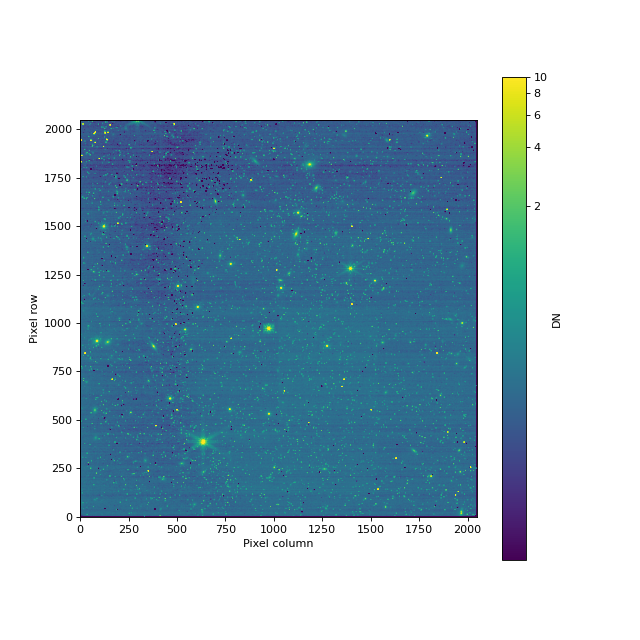

In [ ]:
# Look at the rate image
show_image(rate_data, 0.5, 10)

Compare this to the last frame of an uncalibrated image

In [ ]:
uncal_image = fits.getdata(uncal_file)

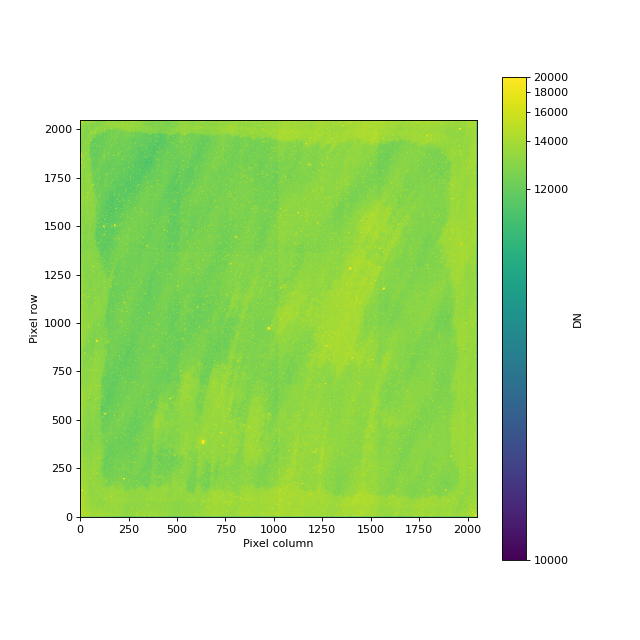

In [ ]:
# Compare this to the last frame of an uncalibrated image
show_image(uncal_image[-1,-1],vmin=10e3,vmax=20e3)

Also, since we set the linearity step's `save_results` parameter to True in our calls above, the pipeline saved the output of the linearity step. In this case, the output file will have the same name as the input uncal file, but with the suffix 'linearity' rather than 'uncal'. 


In [ ]:
# Generate the linear step file name from the uncal file name
linear_file = rate_file.replace('rate.fits', 'linearity.fits')

In [ ]:
# Read in the science data from the linear file
lin_data = fits.getdata(linear_file)

Let's look at the final group of the integration.

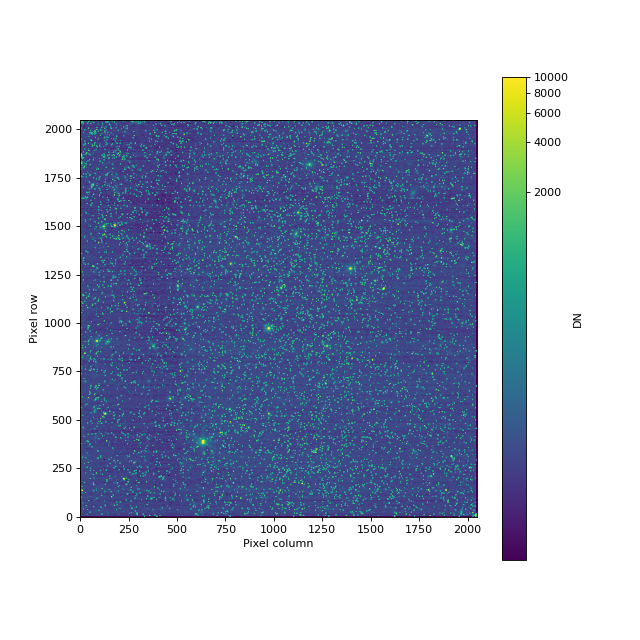

In [ ]:
# Let's look at the data in the final group of the linearized data:
show_image(lin_data[0, -1, :, :], 100, 10000)

### Examine the Saturated Pixels

The pipeline carries along a Data Quality Extension that allows you to see if pixels have been flagged as jumps, saturated, bad/not-used, etc. You can see what flags are available by printing a dictionary of them

In [ ]:
# Print the list of JWST bad pixel types
dqflags.pixel

{'ADJ_OPEN': 134217728,
 'AD_FLOOR': 64,
 'BAD_REF_PIXEL': 131072,
 'DEAD': 1024,
 'DO_NOT_USE': 1,
 'DROPOUT': 8,
 'GOOD': 0,
 'HOT': 2048,
 'JUMP_DET': 4,
 'LOW_QE': 8192,
 'MSA_FAILED_OPEN': 536870912,
 'NONLINEAR': 65536,
 'NON_SCIENCE': 512,
 'NO_FLAT_FIELD': 262144,
 'NO_GAIN_VALUE': 524288,
 'NO_LIN_CORR': 1048576,
 'NO_SAT_CHECK': 2097152,
 'OPEN': 67108864,
 'OTHER_BAD_PIXEL': 1073741824,
 'OUTLIER': 16,
 'PERSISTENCE': 32,
 'RC': 16384,
 'REFERENCE_PIXEL': 2147483648,
 'RESERVED_4': 128,
 'SATURATED': 2,
 'TELEGRAPH': 32768,
 'UNRELIABLE_BIAS': 4194304,
 'UNRELIABLE_DARK': 8388608,
 'UNRELIABLE_ERROR': 256,
 'UNRELIABLE_FLAT': 33554432,
 'UNRELIABLE_RESET': 268435456,
 'UNRELIABLE_SLOPE': 16777216,
 'WARM': 4096}

You can make a map of which pixels saturated by using "bit" operations to see if that flag is true. The `&` operator will return the value and a `> 0` will evaluate if it is true. For example:

In [ ]:
# Create a 2D boolean map of whether a pixel was flagged as saturated.
saturated = (run_output.dq & dqflags.pixel['SATURATED'] > 0)


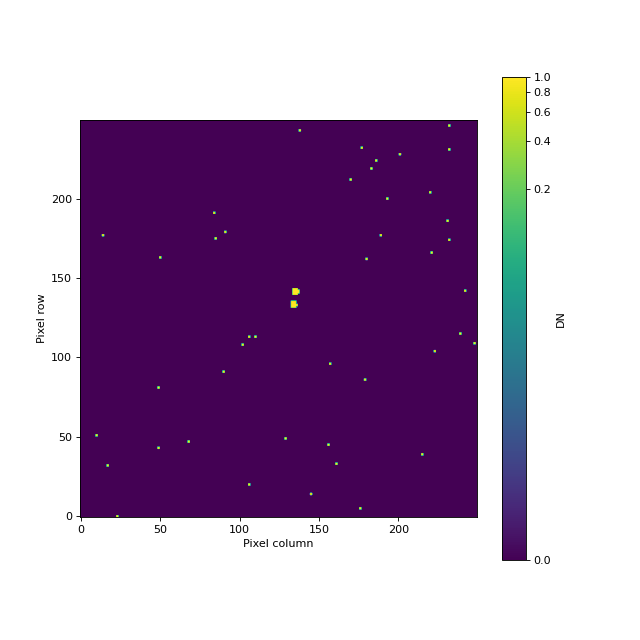

In [ ]:
show_image(saturated[250:500,500:750],vmin=0,vmax=1)

Compare this to the rate image

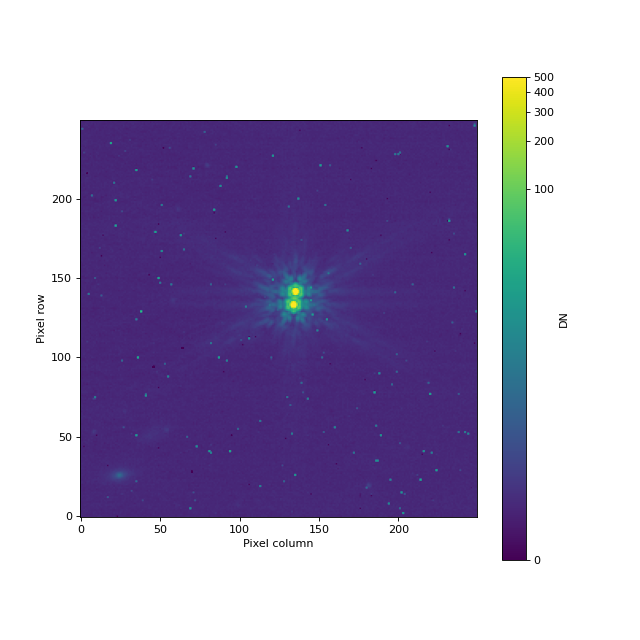

In [ ]:
# Let's look at the data in the final group of the linearized data:
show_image(rate_data[250:500,500:750],vmin=0,vmax=500)

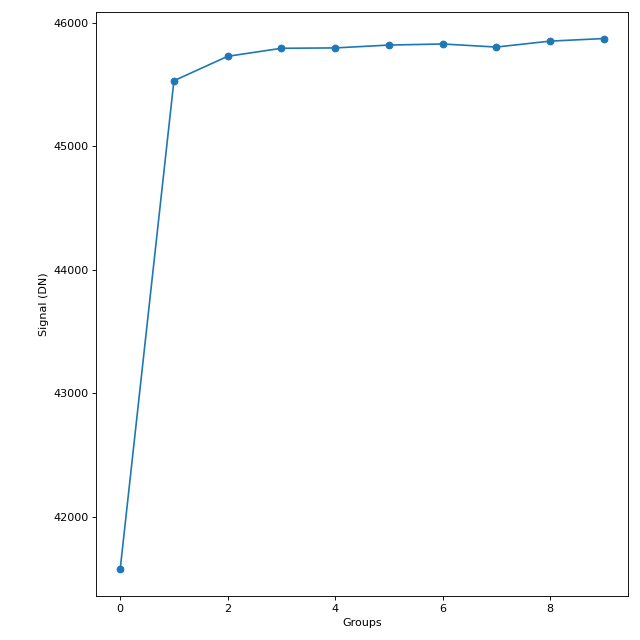

In [ ]:
## read in the uncalibrated raw data
uncal_data = fits.getdata(uncal_file)
## make a group array that counts the groups for the x axis
group_indices = np.arange(run_output.meta.exposure.ngroups)
## find pixels marked as saturated that also have high signal
idy, idx = np.where(saturated & (rate_data > 100))
## Plot a selected pixel
sel_pixel = 3
plot_ramp(group_indices,uncal_data[0,:,idy[sel_pixel],idx[sel_pixel]])

[Top of Notebook](#top)

<a id='exercise1'></a>
## Exercise 1: Run calwebb_detector1 without the reference pixel step

Try to run stage 1 of the pipeline again, this time with the reference pixel step skipped. Then compare the rate image you get with this new result

#### hint
Copy the detector1 steps above. To skip a step, you set that step to skip like so
`detector1.jump.skip = True`

Also, you can save the result to a different directory to have both to compare.
For that, try `detector1.output_dir = 'output_no_refpix'`

In [ ]:
alt_output_dir = 'output_no_refpix'
if os.path.exists(alt_output_dir) == False:
    os.mkdir(alt_output_dir)

In [ ]:
# # Create an instance of the pipeline class
# detector1 = calwebb_detector1.Detector1Pipeline()

# # Set some parameters that pertain to the
# # entire pipeline
# detector1.output_dir = alt_output_dir
# detector1.save_results = True

# # Set some parameters that pertain to some of
# # the individual steps
# #detector1.refpix.use_side_ref_pixels = True
# detector1.refpix.skip = True

# detector1.linearity.save_results = True
# detector1.jump.rejection_threshold = 6

# # Specify the name of the trapsfilled file, which
# # contains the state of the charge traps at the end
# # of the preceding exposure
# detector1.persistence.skip = True

# # Call the run() method
# run_output = detector1.run(uncal_file)

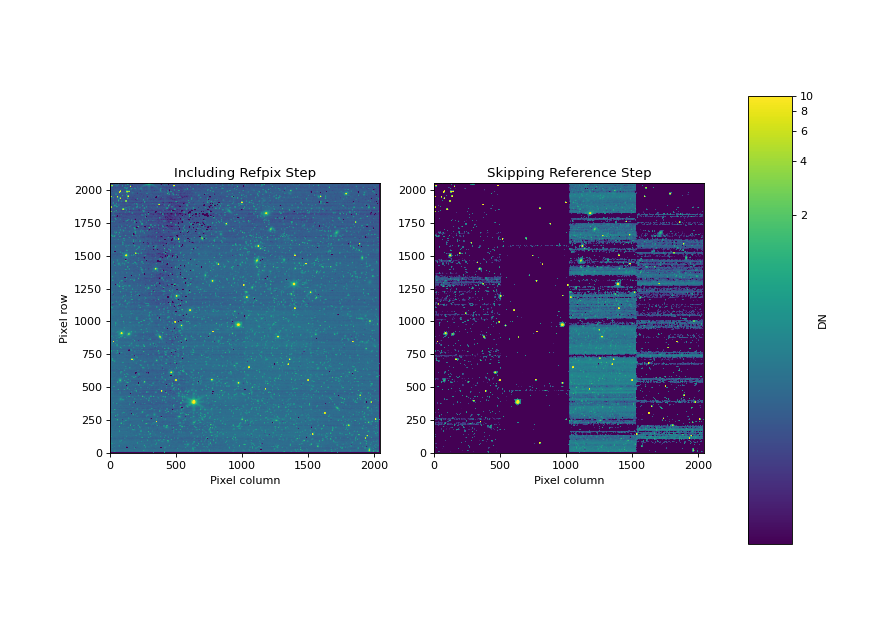

In [ ]:
rate_data_no_refpix = fits.getdata('output_no_refpix/jw98765001001_01101_00003_nrcb5_rate.fits')
side_by_side(rate_data, rate_data_no_refpix, 0.5, 10, title1="Including Refpix Step",
             title2="Skipping Reference Step")

## Exercise 2: Show some pixels that jumped

Find a pixel that was marked as a jump and plot its counts as a function of time

### Hint
use the Dq value and the dqflags, just as we did for saturation

In [ ]:
jumped = (run_output.dq & dqflags.pixel['JUMP_DET']) > 0 

In [ ]:
np.sum(jumped)

62020

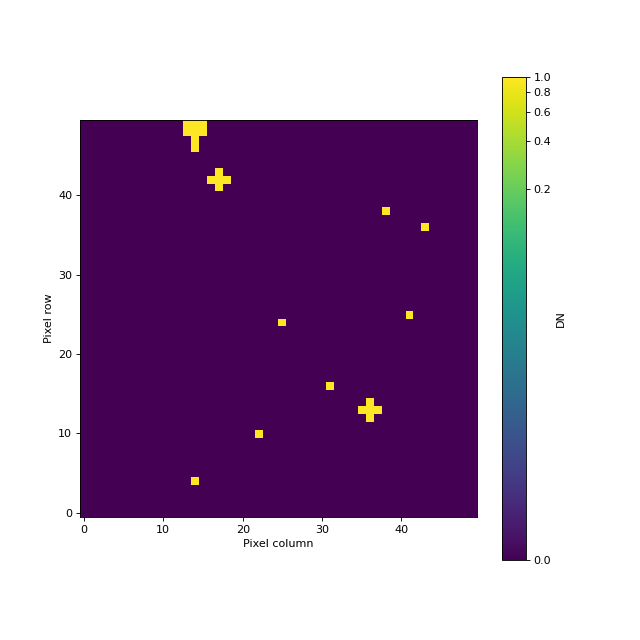

In [ ]:
show_image(jumped[0:50,0:50] ,vmin=0,vmax=1)

In [ ]:
idy, idx = np.where(jumped)

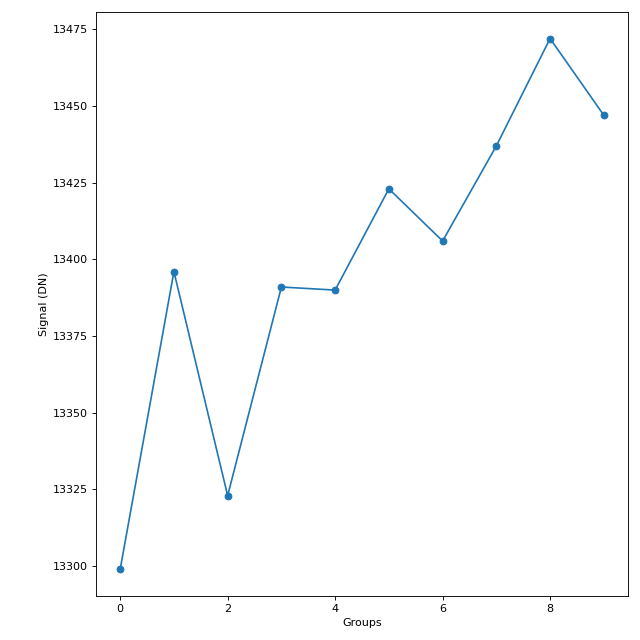

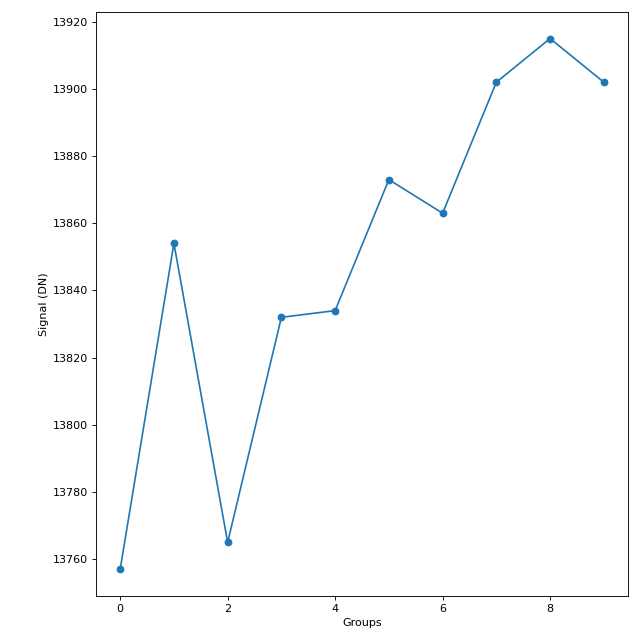

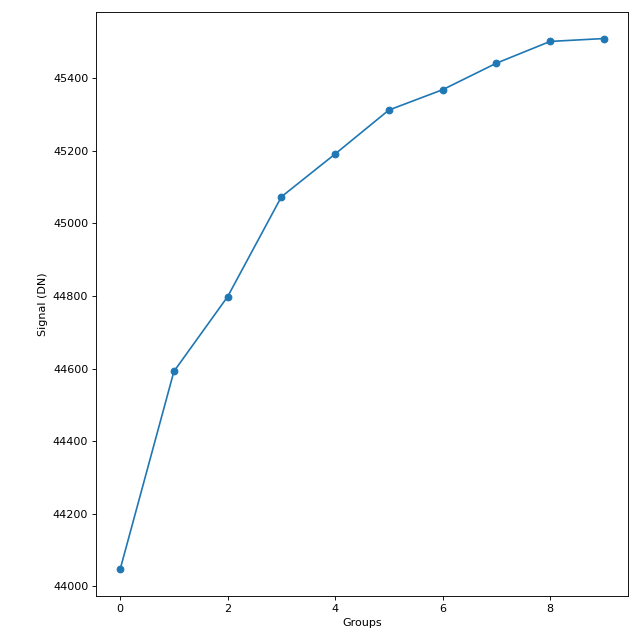

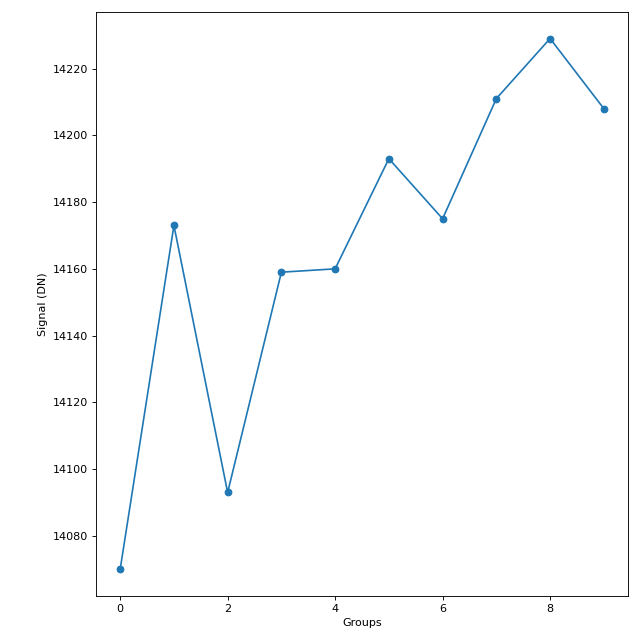

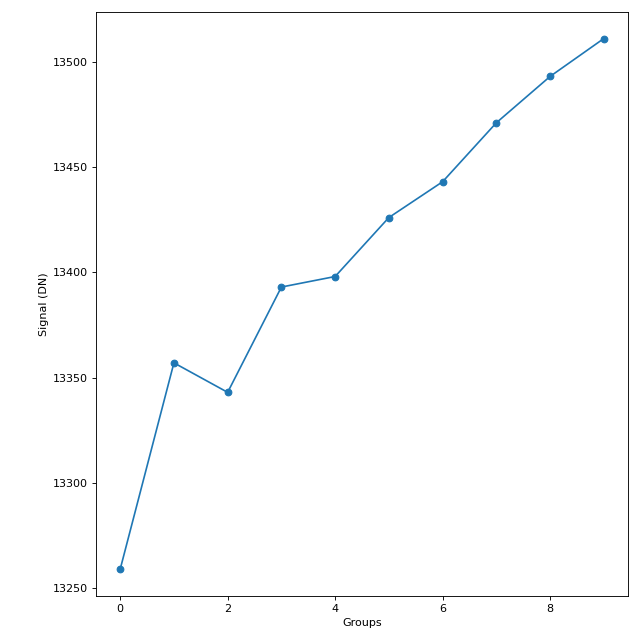

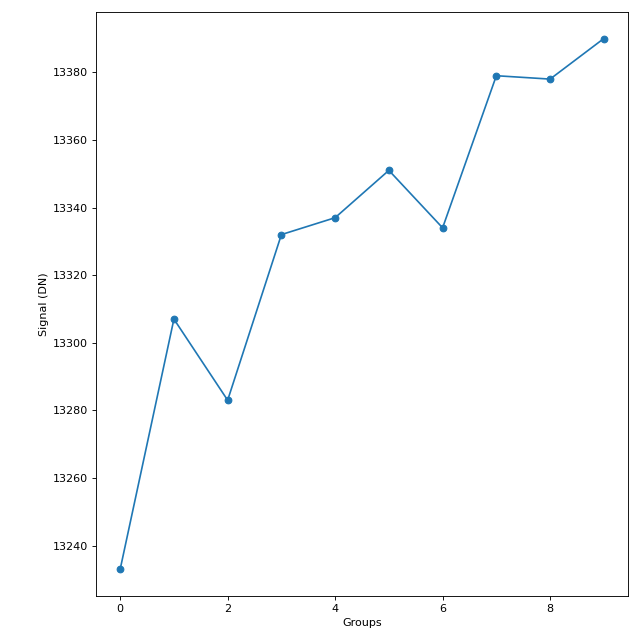

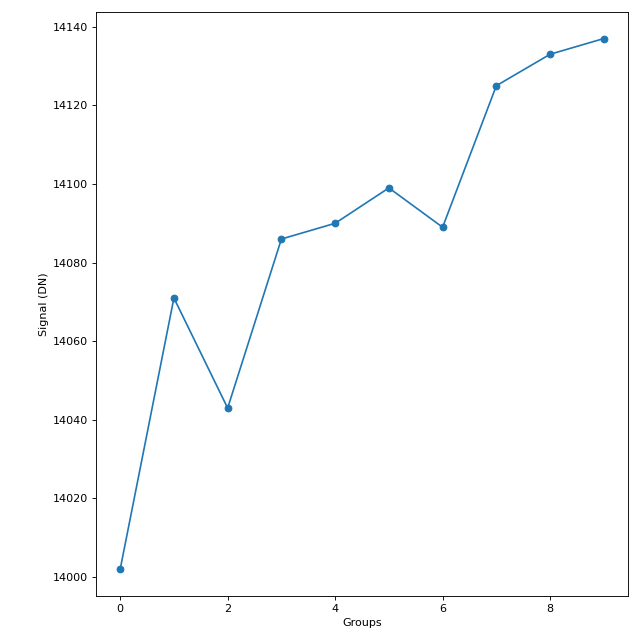

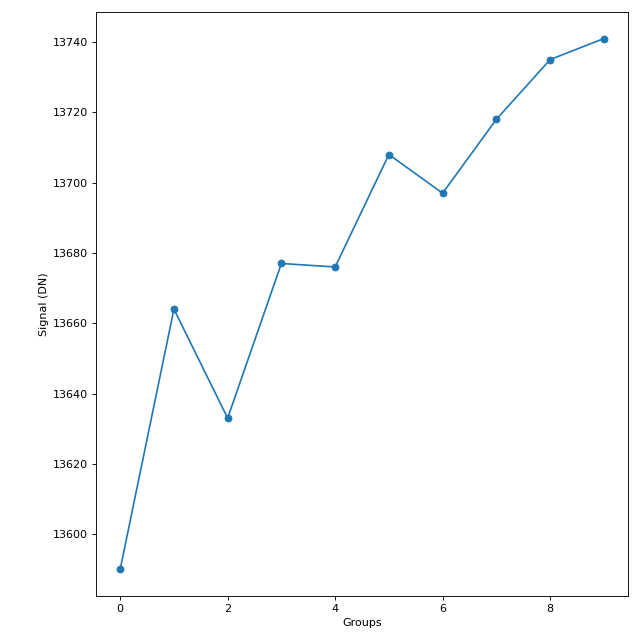

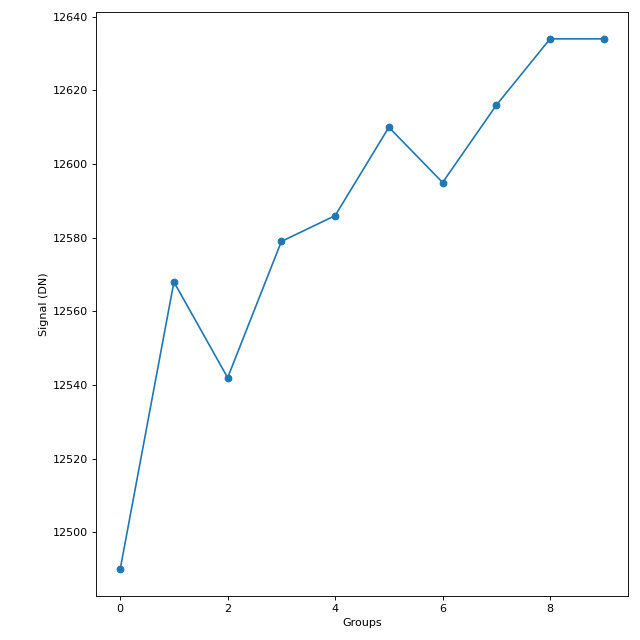

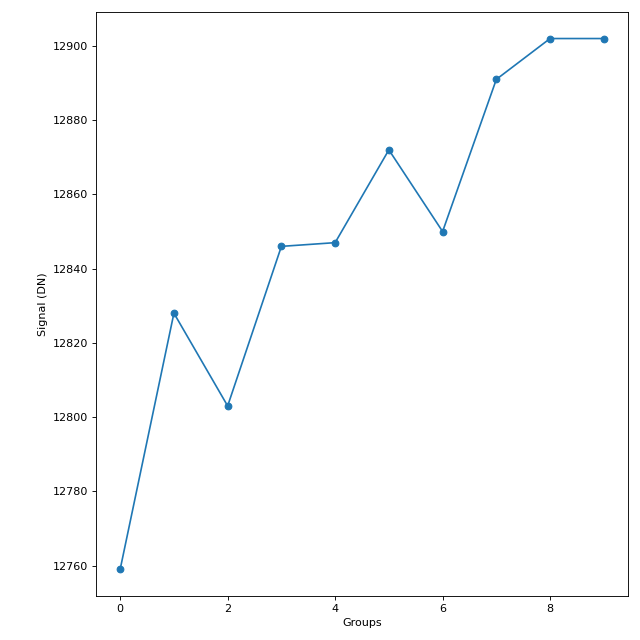

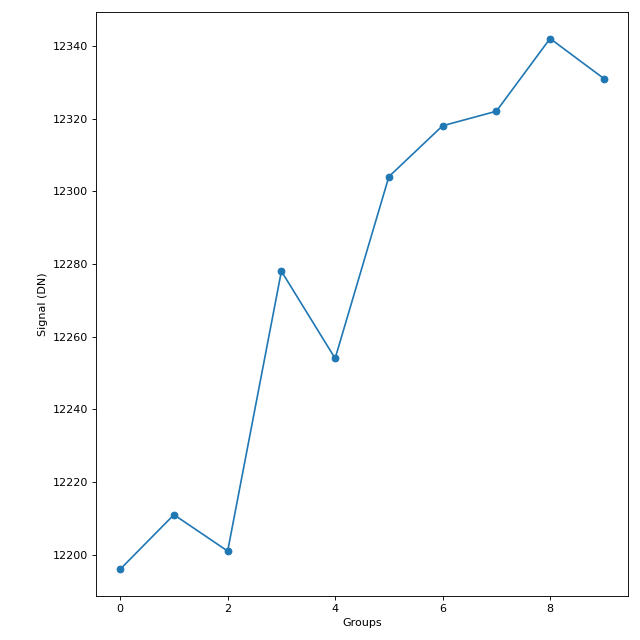

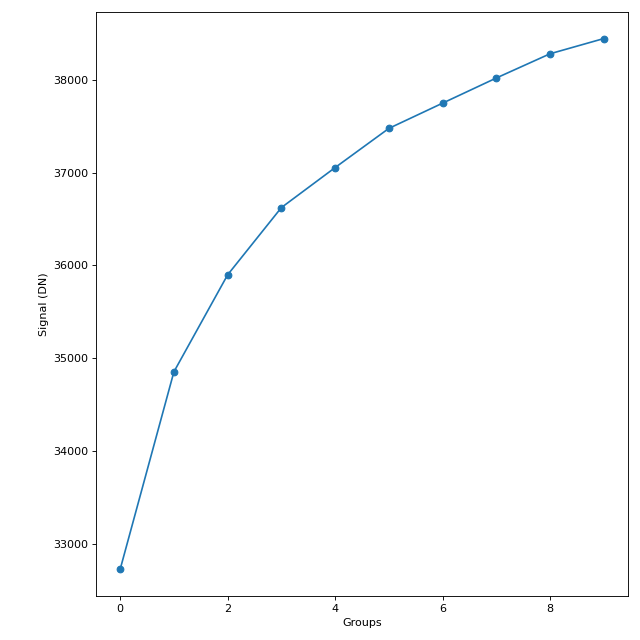

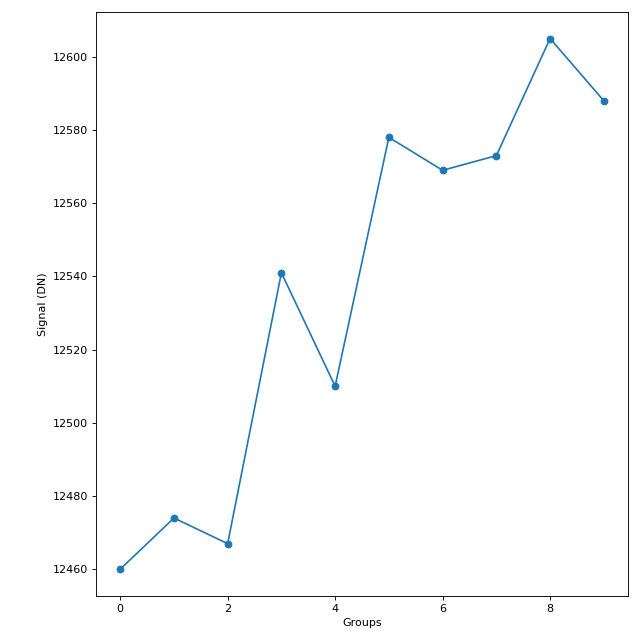

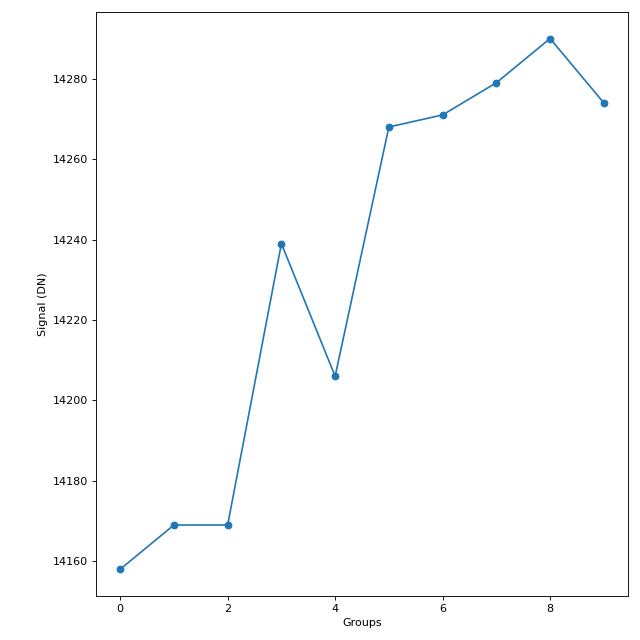

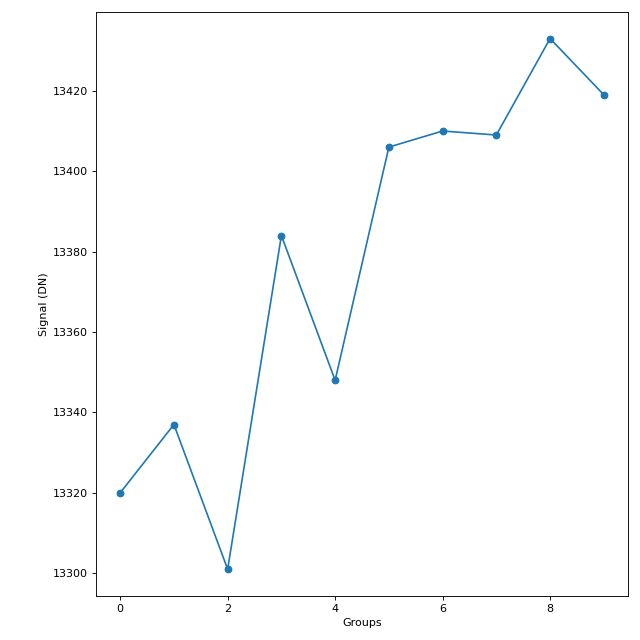

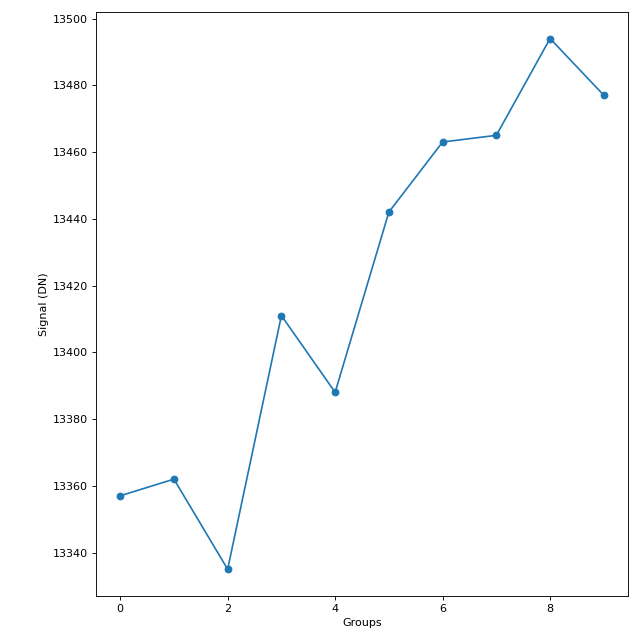

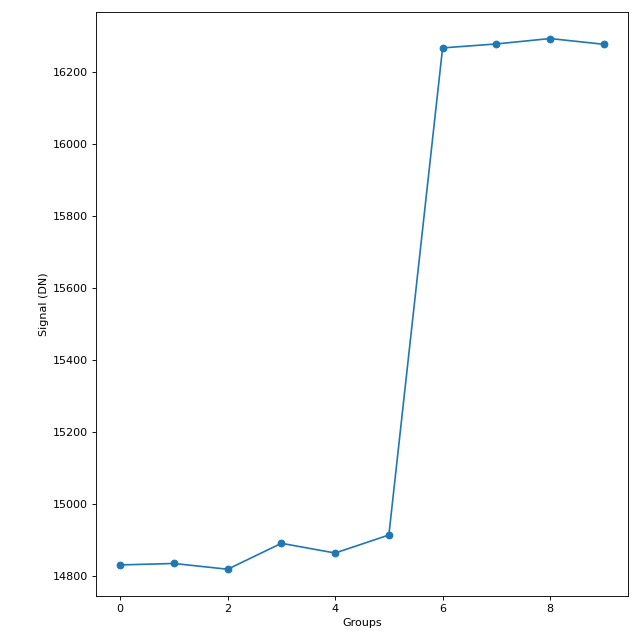

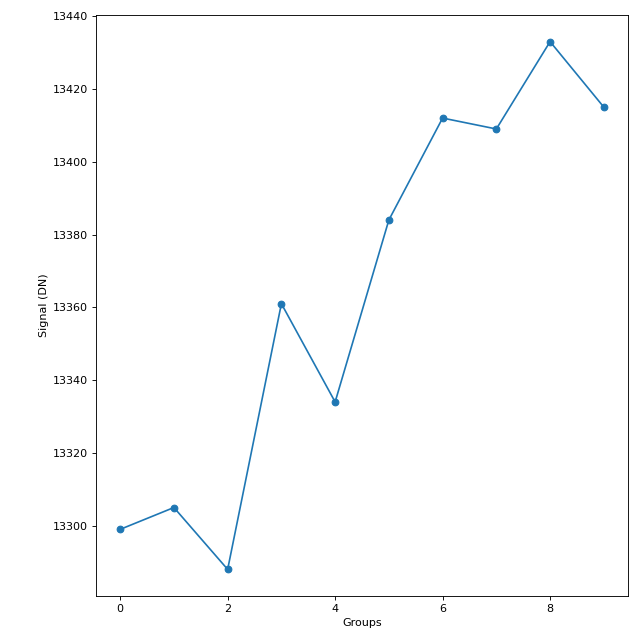

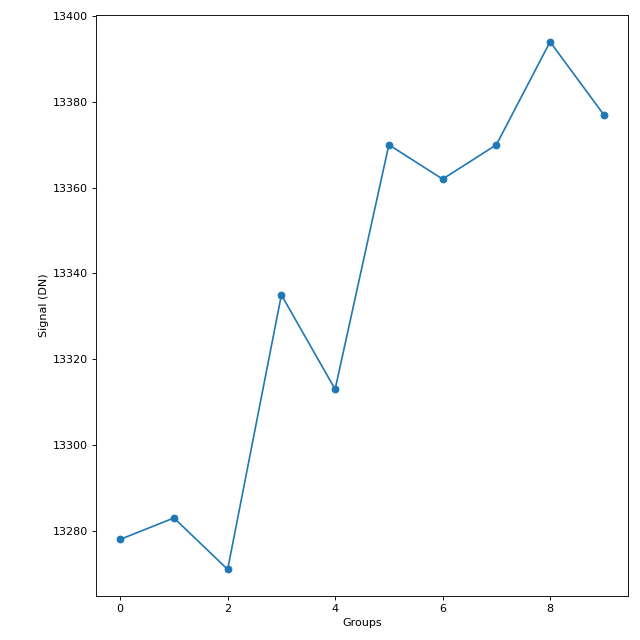

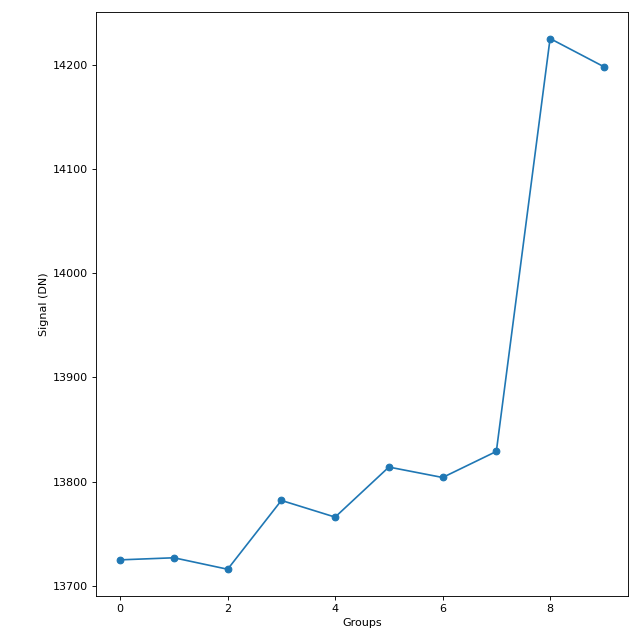

In [ ]:
## find pixels marked as saturated that also have high signal
idy, idx = np.where(jumped)
## Plot a selected pixel

for i in np.arange(1000,1020):
  sel_pixel = i
  plot_ramp(group_indices,uncal_data[0,:,idy[sel_pixel],idx[sel_pixel]])

In [ ]:
fits.getheader(uncal_file)

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
DATE    = '2021-06-08T20:03:42.374' / UTC date file created                     
ORIGIN  = 'STScI   '           / Organization responsible for creating file     
FILENAME= 'jw98765001001_01101_00003_nrcb5_uncal.fits' / Name of the file       
FILETYPE= 'raw     '           / Type of data in the file                       
DATAMODL= 'RampModel'          / Type of data model                             
TELESCOP= 'JWST    '           / Telescope used to acquire the data             
                                                                                
        Program information                                                     
                            

# Imaging Mode Data Calibration: Part 2 - Calibrated Slope Images
---
**Author**: Bryan Hilbert (hilbert@stsci.edu)| **Latest Update**: 20 May 2021
Modified by Everett Schlawin mid-December 2021


<a id='intro'></a>
## Introduction

This notebook covers part 2 of the imaging mode data calibration module. In this notebook we'll review Stage 2 of the JWST calibration pipeline for imaging data, also known as *calwebb\_image2*. 

The [Stage 2 pipeline](https://jwst-pipeline.readthedocs.io/en/stable/jwst/pipeline/calwebb_image2.html) applies instrumental corrections and calibrations to the slope images output from Stage 1. This includes background subtraction, the creation of a full World Coordinate System (WCS) for the data, application of the flat field, and flux calibration. In most cases the final output is an image in units of surface brightness. Whereas the input files had suffixes of `*_rate.fits*`, the output files have suffixes of `*_cal.fits*`.

In addition to the steps above, the Stage 2 pipeline will also run the [resample](https://jwst-pipeline.readthedocs.io/en/stable/jwst/resample/main.html) step on the calibrated images, in order to remove the effects of instrument distortion. This step outputs files with the suffix `*_i2d.fits*` that contain "rectified" images. However, these files are meant only for user examination of the data. It is the `*_cal.fits*` files that are passed on to Stage 3 of the pipeline.

To illustrate how the steps of the pipeline change the input data, we will download several sample files and run them through the pipeline, examining the results at several places along the way.

All JWST imaging mode data, regardless of instrument, are processed through the *calwebb\_image2* pipeline. The steps and the order in which they are performed is the same for all data. For the purposes of this notebook, we will continue with the processing of the NIRCam data used in the Stage 1 notebook. We will also provide example MIRI files that can be used in a separate exercise.

<a id='resources'></a>
## Pipeline Resources and Documentation

There are several different places to find information on installing and running the pipeline. This notebook will give a shortened description of the steps pulled from the detailed pipeline information pages, but to find more in-depth instructions use the links below.

* [JWST Documentation (JDox) for the Stage 2 pipeline](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline-overview/stages-of-jwst-data-processing/calwebb_image2) including short a short summary of what each step does.

* [High-level description of all pipeline stages and steps](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/main.html)

* [`jwst` package documentation](https://jwst-pipeline.readthedocs.io/en/latest/jwst/introduction.html) including how to run the pipeline, input/output files, etc.

* [`jwst` package GitHub repository, with installation instructions](https://github.com/spacetelescope/jwst/blob/master/README.md)

* [**Help Desk**](https://stsci.service-now.com/jwst?id=sc_cat_item&sys_id=27a8af2fdbf2220033b55dd5ce9619cd&sysparm_category=e15706fc0a0a0aa7007fc21e1ab70c2f): **If you have any questions or problems regarding the pipeline, submit a ticket to the Help Desk**

Import JWST pipeline-related modules

In [ ]:
# The entire calwebb_image2 pipeline
from jwst.pipeline import calwebb_image2

# Individual steps that make up calwebb_image2
from jwst.background import BackgroundStep
from jwst.assign_wcs import AssignWcsStep
from jwst.flatfield import FlatFieldStep
from jwst.photom import PhotomStep
from jwst.resample import ResampleStep
from jwst import datamodels

<a id='download_data'></a>
## Download Data
For this module, we will use rate files from a NIRCam simulated imaging exposure that is stored in Box. Let's grab them:

Download the rate files, association file, and parameter reference file, so that we have inputs to work with.

In [ ]:
nircam_info = [('https://stsci.box.com/shared/static/g6316wjr4mv936rlouzdjeq065s7ou6g.fits',
                'jw98765001001_01101_00001_nrcb5_rate.fits'),
               ('https://stsci.box.com/shared/static/z2xunff1d2g3m3fjxc1fixoz8rjfpl7h.fits',
                'jw98765001001_01101_00002_nrcb5_rate.fits'),
               ('https://stsci.box.com/shared/static/4xuvt56kr7gix7dx3tntek6wc9kockef.fits',
                'jw98765001001_01101_00003_nrcb5_rate.fits'),
               ('https://stsci.box.com/shared/static/lzhcnzds2l7mpf92oet1u69uof788u3l.json',
                'level2_lw_asn.json'),
               ('https://stsci.box.com/shared/static/d4pu8ieyjc27wzoe0of3ajb9vjtvc80g.asdf',
                'image2_pipeline_params.asdf')]
nircam_files = download_files(nircam_info, output_dir, force=False)

jw98765001001_01101_00001_nrcb5_rate.fits already exists, skipping download...
jw98765001001_01101_00002_nrcb5_rate.fits already exists, skipping download...
jw98765001001_01101_00003_nrcb5_rate.fits already exists, skipping download...
level2_lw_asn.json already exists, skipping download...
image2_pipeline_params.asdf already exists, skipping download...


<a id='associations'></a>
## Association Files

The Stage 2 pipeline can be called on a single fits file, or a collection of fits files. When calling on multiple files, the input is a json-formatted file called an ["association" file](https://jwst-pipeline.readthedocs.io/en/stable/jwst/associations/index.html) that lists each of the fits files to be processed. 

* An association is a means of identifying a set of exposures that belong together and may be dependent upon one another.
* The association concept permits exposures to be calibrated, archived, retrieved, and reprocessed as a set rather than as individual objects.

When retrieving your observations from MAST, you will be able to download the association files for your data along with the fits files containing the observations.

The association file presents your data files in organized groups. Let's open the level 2 association file for the data to be processed in this notebook and look at its contents.

In [ ]:
# Open the file and load into json object
asn_file = os.path.join(output_dir, 'level2_lw_asn.json')

In [ ]:
with open(asn_file) as f_obj:
  asn_data = json.load(f_obj)
asn_data

{'asn_id': 'a3001',
 'asn_pool': 'none',
 'asn_rule': 'DMSLevel2bBase',
 'asn_type': 'None',
 'code_version': '0.17.1',
 'constraints': 'No constraints',
 'degraded_status': 'No known degraded exposures in association.',
 'products': [{'members': [{'expname': 'jw98765001001_01101_00001_nrcb5_rate.fits',
     'exptype': 'science'}],
   'name': 'jw98765001001_01101_00001_nrcb5'},
  {'members': [{'expname': 'jw98765001001_01101_00002_nrcb5_rate.fits',
     'exptype': 'science'}],
   'name': 'jw98765001001_01101_00002_nrcb5'},
  {'members': [{'expname': 'jw98765001001_01101_00003_nrcb5_rate.fits',
     'exptype': 'science'}],
   'name': 'jw98765001001_01101_00003_nrcb5'}],
 'program': 'noprogram',
 'version_id': None}

Here we see that the association file begins with a few lines of data that give high-level information about the association. The most important entry here is the `asn_rule` field. Association files have different formats for the different stages of the pipeline. You should be sure that the `asn_rule` matches the pipeline that you will be running. In this case we'll be running the Stage 2 pipeline, and we see that the `asn_rule` mentions "Level2b", which is what we want.

Beneath these lines, we see the `products` field. This field contains a list of dictionaries that specify the files that belong to this association, and the types of those files. When the Stage 2 pipeline is run on this association file, all files listed here will be run through the calibration steps.

---
<a id='image2'></a>
## The calwebb_image2 pipeline: Calibrated slope images

In the sections below, we will run the Stage 2 pipeline using an association file containing several NIRCam exposures. We will first call the entire *calwebb_image2* pipeline itself. The pipeline is a wrapper which will string together all of the appropriate steps in the proper order. The final outputs from this call are a calibrated slope image which is ready to go into the Stage 3 pipeline (with a suffix of `_cal.fits`), as well as a calibrated slope image which has been resampled in order to remove distortion effects (with a suffix of `_i2d.fits`). The latter is only for user-examination. The `_cal.fits` file is used as input to the Stage 3 pipeline. Note that the units in these output images are now physical units (MJy/str), rather than DN/sec.

After running the entire pipeline, we will go back to the original uncalibrated slope images and manually run them through each of the steps that comprise the Stage 2 pipeline. For each step we will describe in more detail what is going on and examine how the exposure files have changed.

See [Figure 1](https://jwst-docs.stsci.edu/jwst-data-reduction-pipeline/stages-of-processing/calwebb_image2) on the calwebb_image2 algorithm page for a map of the steps are performed on the input data.


<a id='image2_at_once'></a>
### Run the entire `calwebb_image2` pipeline

In this section we show how to run the entire calwebb_image2 pipeline with a single call. 

We set parameter values for some of the individual steps, save some outputs, etc, and then call the pipeline.

We will call the pipeline using the `run()` method and while that is running, we will go over the equivalent `call()` and `strun` commands, examine some of the pipeline log entries that are printed to the screen, and then look at the pipeline output.

<a id='run_method'></a>
#### Call the pipeline using the run() method

When using the `run()` method to execute a pipeline (or step), the pipeline class is first instantiated without the data to be processed. Optional input parameters are specified using attributes of the class instance. Finally, the call to the `run()` method is made and the data are supplied.  See here for [more examples of the run() method](https://jwst-pipeline.readthedocs.io/en/stable/jwst/stpipe/call_via_run.html).

The `run()` method does not take any kind of parameter reference file as input. If you wish to set values for various parameters, you must do that manually. Below, we set several paramaters in order to show how it's done. 

How do you know what parameters are available to be set and what their default values are? The `spec` property for individual steps will list them. The property is less useful for the pipelines themselves, as it does not show the parameters for the steps compirising the pipeline.

All steps and pipelines have several common parameters that can be set. 

* `save_results` specifies whether or not to save the output of that step/pipeline to a file. The default is False.
* `output_dir` is the directory into which the output files will be saved.
* `output_file` is the base filename to use for the saved result. Note that each step/pipeline will add a custom suffix onto output_file. 

Let's look at the available parameters for the resample step, and manually set some of these in our call to `run()`.

In [ ]:
print(ResampleStep.spec)


        pixfrac = float(default=1.0)
        kernel = string(default='square')
        fillval = string(default='INDEF')
        weight_type = option('ivm', 'exptime', default='ivm')
        pixel_scale_ratio = float(default=1.0) # Ratio of output to input pixel scale
        single = boolean(default=False)
        blendheaders = boolean(default=True)
        allowed_memory = float(default=None)  # Fraction of memory to use for the combined image.
    


<a id='detector1_using_run'></a>

<div class="alert alert-block alert-info">
Finally, let's run the pipeline. The output can be a little overwhelming. There will be multiple log entries printed to the screen for each step.
</div>

In [ ]:
# Create an instance of the pipeline class
image2 = calwebb_image2.Image2Pipeline()

# Set some parameters that pertain to the
# entire pipeline
image2.output_dir = output_dir
image2.save_results = True

# Set some parameters that pertain to some of
# the individual steps
image2.resample.pixfrac = 1.0    # this is the default. Set here as an example

# Call the run() method
image2.run(asn_file)

2021-12-20 18:41:23,870 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.
2021-12-20 18:41:23,875 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2021-12-20 18:41:23,880 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2021-12-20 18:41:23,885 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.
2021-12-20 18:41:23,890 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.
2021-12-20 18:41:23,895 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.
2021-12-20 18:41:24,111 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args ('./level2_lw_asn.json',).
2021-12-20 18:41:24,120 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': './', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': No

[<ImageModel(2048, 2048) from jw98765001001_01101_00001_nrcb5_cal.fits>,
 <ImageModel(2048, 2048) from jw98765001001_01101_00002_nrcb5_cal.fits>,
 <ImageModel(2048, 2048) from jw98765001001_01101_00003_nrcb5_cal.fits>]

This cell will take a few minutes to run.

### Examine the outputs

In [ ]:
# Get a list of input file names from the association file
input_files = [item['members'][0]['expname'] for item in asn_data['products']] 
input_files      

['jw98765001001_01101_00001_nrcb5_rate.fits',
 'jw98765001001_01101_00002_nrcb5_rate.fits',
 'jw98765001001_01101_00003_nrcb5_rate.fits']

In [ ]:
# Get a list of the output file names
output_files = sorted(glob(os.path.join(output_dir, '*_cal.fits')))
output_files

['./jw98765001001_01101_00001_nrcb5_cal.fits',
 './jw98765001001_01101_00002_nrcb5_cal.fits',
 './jw98765001001_01101_00003_nrcb5_cal.fits']

In [ ]:
# Open the first calibrated output file
cal_data = fits.open(output_files[0])

In [ ]:
# Check the contents of the calibrated file
cal_data.info()

Filename: ./jw98765001001_01101_00001_nrcb5_cal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     262   ()      
  1  SCI           1 ImageHDU        85   (2048, 2048)   float32   
  2  ERR           1 ImageHDU        10   (2048, 2048)   float32   
  3  DQ            1 ImageHDU        11   (2048, 2048)   int32 (rescales to uint32)   
  4  AREA          1 ImageHDU         9   (2048, 2048)   float32   
  5  VAR_POISSON    1 ImageHDU         9   (2048, 2048)   float32   
  6  VAR_RNOISE    1 ImageHDU         9   (2048, 2048)   float32   
  7  VAR_FLAT      1 ImageHDU         9   (2048, 2048)   float32   
  8  ASDF          1 BinTableHDU     11   1R x 1C   [17271B]   


Let's look at the header of the SCI extension, to see the information that has been added by the assign WCS and flux calibration steps.

In [ ]:
cal_data['SCI'].header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 2048                                                  
NAXIS2  =                 2048                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
EXTNAME = 'SCI     '           / extension name                                 
BUNIT   = 'MJy/sr  '           / physical units of the array values             
                                                                                
        Photometry information                                                  
                                                                                
PHOTMJSR=   0.38998839259147

In [ ]:
# Get the name of the `i2d` file associated with the first output file
i2d_file = output_files[0].replace('cal.fits', 'i2d.fits')
# Extract the data from the i2d file so we can look at it.
i2d_data = fits.getdata(i2d_file)

<a id='pipeline_output_view'></a>
Display the calibrated slope image and the distortion-free output file

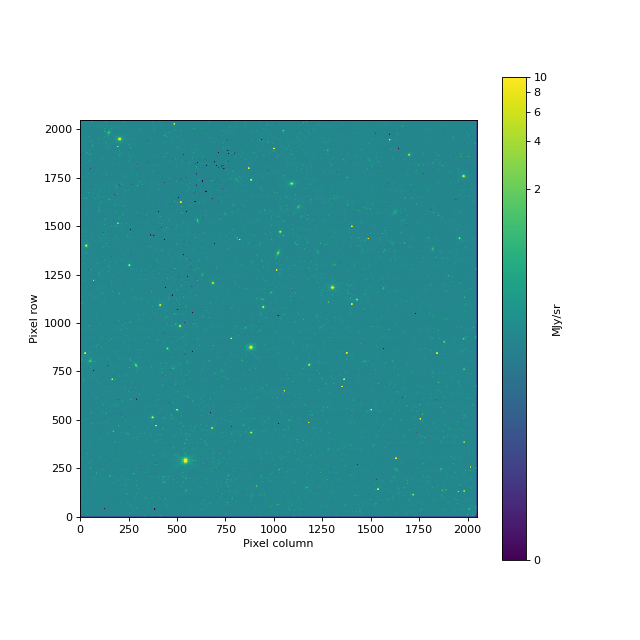

In [ ]:
show_image(cal_data['SCI'].data, 0., 10,unit='MJy/sr')

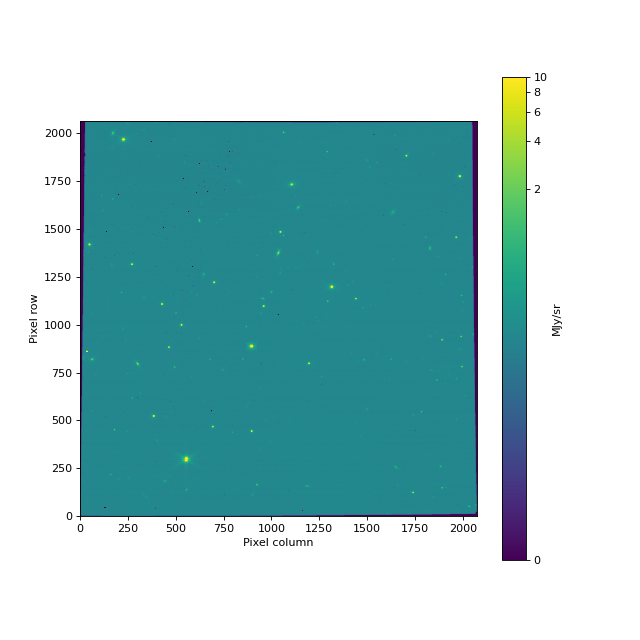

In [ ]:
show_image(i2d_data, 0, 10,unit='MJy/sr')

<a id='top'></a>
# Imaging Mode Data Calibration: Part 3 - Observation Level Calibrations
---
**Author**: Bryan Hilbert (hilbert@stsci.edu)| **Latest Update**: 20 May 2021

Modified by Everett Schlawin in mid-December 2021

<a id='intro'></a>
## Introduction

This notebook covers part 3 of the imaging mode data calibration module. In this notebook we'll review Stage 3 of the JWST calibration pipeline for imaging data, also known as *calwebb\_image3*. 

The [Stage 3 pipeline](https://jwst-pipeline.readthedocs.io/en/stable/jwst/pipeline/calwebb_image3.html) takes one or more calibrated slope images (`*_cal.fits` files) and combines them into a final mosaic image. It then creates a source catalog from this mosaic. Several steps are performed in order to prepare the data for the mosaic creation. These steps largely mirror what is done by [DrizzlePac](https://www.stsci.edu/scientific-community/software/drizzlepac.html) software when working with HST data. 

First, using common sources found across the input images, the WCS of each image is refined. Background levels are then matched across the inputs. Spurious sources (e.g. cosmic rays that were not flagged in the `jump` step during Stage 1 processing) are removed by comparing each individual input image to a median image. The indivudal images are combined into a single mosaic image. A source catalog is created based on the mosaic image. And finally, the individual exposures are updated using the information from the preceding steps. New versions of the individual calibrated slope images (`*_cal.fits` files) are produced that contain matched backgrounds, flagged spurious sources, and improved WCS objects. Also, updated [resampled](https://jwst-pipeline.readthedocs.io/en/stable/jwst/resample/main.html) images (`_i2d.fits` files) are created which all contain the final undistorted sky projection that is present in the mosaic image.

There are three final outputs. The first is updated copies of the input files. These updated files contain a consistent WCS, such that they overlap correctly. The second output is a final mosaic image created by drizzling the input images onto a distortion-free grid. And the final output is a source catalog wth basic photometry, created from the final mosaic image.

To illustrate how the steps of the pipeline change the input data, we will download several sample files and run them through the pipeline, examining the results at several places along the way.

All JWST imaging mode data, regardless of instrument, are processed through the *calwebb\_image3* pipeline. The steps and the order in which they are performed is the same for all data. For the purposes of this notebook, we will continue with the processing of the NIRCam data used in the Stages 1 and 2 notebooks. We will also provide example MIRI files that can be used in a separate exercise.

<a id='resources'></a>
## Pipeline Resources and Documentation

There are several different places to find information on installing and running the pipeline. This notebook will give a shortened description of the steps pulled from the detailed pipeline information pages, but to find more in-depth instructions use the links below.

* [JWST Documentation (JDox) for the Stage 3 pipeline](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline-overview/stages-of-jwst-data-processing/calwebb_image3) including short a short summary of what each step does.

* [High-level description of all pipeline stages and steps](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/main.html)

* [`jwst` package documentation](https://jwst-pipeline.readthedocs.io/en/latest/jwst/introduction.html) including how to run the pipeline, input/output files, etc.

* [`jwst` package GitHub repository, with installation instructions](https://github.com/spacetelescope/jwst/blob/master/README.md)

* [**Help Desk**](https://stsci.service-now.com/jwst?id=sc_cat_item&sys_id=27a8af2fdbf2220033b55dd5ce9619cd&sysparm_category=e15706fc0a0a0aa7007fc21e1ab70c2f): **If you have any questions or problems regarding the pipeline, submit a ticket to the Help Desk**

Import steps

In [ ]:
# The entire calwebb_image3 pipeline
from jwst.pipeline import calwebb_image3

# Individual steps that make up calwebb_image3
from jwst.tweakreg import TweakRegStep
from jwst.skymatch import SkyMatchStep
from jwst.outlier_detection import OutlierDetectionStep
from jwst.resample import ResampleStep
from jwst.source_catalog import SourceCatalogStep
from jwst import datamodels
from jwst.associations import asn_from_list
from jwst.associations.lib.rules_level3_base import DMS_Level3_Base

Convenience Functions

In [ ]:
def overlay_catalog(data_2d, catalog, flux_limit=0, vmin=0, vmax=10,
                    title=None, units='MJy/str'):
    """Function to generate a 2D image of the data, 
    with sources overlaid.
    
    data_2d : numpy.ndarray
        2D image to be displayed
        
    catalog : astropy.table.Table
        Table of sources
    
    flux_limit : float
        Minimum signal threshold to overplot sources from catalog.
        Sources below this limit will not be shown on the image.
        
    vmin : float
        Minimum signal value to use for scaling
        
    vmax : float
        Maximum signal value to use for scaling
        
    title : str
        String to use for the plot title
                
    units : str
        Units of the data. Used for the annotation in the
        color bar
    """
    norm = ImageNormalize(data_2d, interval=ManualInterval(vmin=vmin, vmax=vmax),
                              stretch=LogStretch())
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)
    im = ax.imshow(data_2d, origin='lower', norm=norm)
    
    for row in catalog:
        if row['aper_total_flux'].value > flux_limit:
            plt.plot(row['xcentroid'], row['ycentroid'], marker='o',
                     markersize='3', color='red')

    plt.xlabel('Pixel column')
    plt.ylabel('Pixel row')
    
    fig.colorbar(im, label=units)
    fig.tight_layout()
    plt.subplots_adjust(left=0.15)
    
    if title:
        plt.title(title)

# Download Data
For this module, we will use calbrated rate files from a NIRCam simulated imaging exposure that is stored in Box. Let's download these files, as well as an association file and some parameter reference files.

In [ ]:
nircam_info = [('https://stsci.box.com/shared/static/p2wlvndw25dk7xwk1tasqevmhkg6p55e.fits',
                'jw98765001001_01101_00001_nrcb5_cal.fits'),
               ('https://stsci.box.com/shared/static/cmhc7kkf5z6373d2vwg7916lrhe5ia7u.fits',
                'jw98765001001_01101_00002_nrcb5_cal.fits'),
               ('https://stsci.box.com/shared/static/sb18cpfqjbw1i09gvw0cpqkj6ymdn899.fits',
                'jw98765001001_01101_00003_nrcb5_cal.fits'),
               ('https://stsci.box.com/shared/static/7d00b9isvss7njhcwmd8uiq8c7s4d845.json',
                'level3_lw_asn.json'),
               ('https://stsci.box.com/shared/static/ja0gkd8c0x8p8konhr84wkuhwnpkqf4s.asdf',
                'jwst_nircam_pars-tweakregstep_0006.asdf'),
               ('https://stsci.box.com/shared/static/yahdw55fotwrh7i6hhcxksj97qkf7j4r.asdf',
                'nircam_pars-sourcecatalogstep_f444w_clear.asdf')
              ]
nircam_files = download_files(nircam_info, output_dir, force=False)

jw98765001001_01101_00001_nrcb5_cal.fits already exists, skipping download...
jw98765001001_01101_00002_nrcb5_cal.fits already exists, skipping download...
jw98765001001_01101_00003_nrcb5_cal.fits already exists, skipping download...
level3_lw_asn.json already exists, skipping download...
jwst_nircam_pars-tweakregstep_0006.asdf already exists, skipping download...
nircam_pars-sourcecatalogstep_f444w_clear.asdf already exists, skipping download...


<a id='associations'></a>
## Association Files

The Stage 3 pipeline must be called using a json-formatted file called an ["association" file](https://jwst-pipeline.readthedocs.io/en/stable/jwst/associations/index.html). When retrieving your observations from MAST, you will be able to download the association files for your data along with the fits files containing the observations.

The association file presents your data files in organized groups. Let's open the level 3 association file for the data to be processed in this notebook and look at its contents.

In [ ]:
asn_file = os.path.join(output_dir, 'level3_lw_asn.json')

In [ ]:
# Open the association file and load into a json object
with open(asn_file) as f_obj:
  asn_data = json.load(f_obj)

In [ ]:
asn_data

{'asn_id': 'a3001',
 'asn_pool': 'none',
 'asn_rule': 'DMS_Level3_Base',
 'asn_type': 'None',
 'code_version': '0.17.1',
 'constraints': 'No constraints',
 'degraded_status': 'No known degraded exposures in association.',
 'products': [{'members': [{'expname': 'jw98765001001_01101_00001_nrcb5_cal.fits',
     'exptype': 'science'},
    {'expname': 'jw98765001001_01101_00002_nrcb5_cal.fits',
     'exptype': 'science'},
    {'expname': 'jw98765001001_01101_00003_nrcb5_cal.fits',
     'exptype': 'science'}],
   'name': 'l3_lw_results'}],
 'program': 'noprogram',
 'target': 'none',
 'version_id': None}

Here we see that the association file begins with a few lines of data that give high-level information about the association. The most important entry here is the `asn_rule` field. Association files have different formats for the different stages of the pipeline. You should be sure that the `asn_rule` matches the pipeline that you will be running. In this case we'll be running the Stage 3 pipeline, and we see that the `asn_rule` mentions "Level3", which is what we want.

Beneath these lines, we see the `products` field. This field contains a list of dictionaries that specify the files that belong to this association, and the types of those files. When the Stage 3 pipeline is run on this association file, all files listed here will be run through the calibration steps.

<a id='diy_association'></a>
##### Creating your own association files

As we will see below, when calling the steps of the pipeline one at a time, you can provide each step with either the output object from the preceding step, or you can provide an association file. Generally the former is easier to do. 

Since each step outputs modified observation files, in order to provide an association file for each step, you'll have to make a new association file for each step that lists the new observation files. Here we will show an example of how to create a new association file for the Stage 3 pipeline or pipeline steps. Keep in mind that you may also simply make a copy of an existing association file and update the member filenames.

We'll use the [`asn_from_list()` function](https://jwst-pipeline.readthedocs.io/en/stable/api/jwst.associations.asn_from_list.asn_from_list.html#jwst.associations.asn_from_list.asn_from_list) to create the new association file designed to be used in the `skymatch` step using as input the outputs from the `tweakreg` step. As input, we need the list of member files, as well as the product name. The product name will be prepended onto the output filenames by the pipeline or step that uses this association file.

In [ ]:
tweak_files = ['level3_lw_asn_0_tweakregstep.fits',
               'level3_lw_asn_1_tweakregstep.fits',
               'level3_lw_asn_2_tweakregstep.fits']
tweak_product = 'manual_asn_file'

In [ ]:
tweakreg_asn = asn_from_list.asn_from_list(tweak_files, rule=DMS_Level3_Base, product_name=tweak_product)

Here is our new association, containing the three files created by the `tweakreg` step.

In [ ]:
tweakreg_asn

{
    "asn_type": "None",
    "asn_rule": "DMS_Level3_Base",
    "version_id": null,
    "code_version": "1.3.3",
    "degraded_status": "No known degraded exposures in association.",
    "program": "noprogram",
    "constraints": "No constraints",
    "asn_id": "a3001",
    "target": "none",
    "asn_pool": "none",
    "products": [
        {
            "name": "manual_asn_file",
            "members": [
                {
                    "expname": "level3_lw_asn_0_tweakregstep.fits",
                    "exptype": "science"
                },
                {
                    "expname": "level3_lw_asn_1_tweakregstep.fits",
                    "exptype": "science"
                },
                {
                    "expname": "level3_lw_asn_2_tweakregstep.fits",
                    "exptype": "science"
                }
            ]
        }
    ]
}

Now save the new association to a json file.

In [ ]:
output_test = 'manual_tweakreg_asn.json'
with open(output_test, 'w') as outfile:
    name, serialized = tweakreg_asn.dump(format='json')
    outfile.write(serialized)

<a id='calling_methods'></a>
## Methods for calling steps/pipelines

There are three common methods by which the pipeline or pipeline steps can be called. From within python, the `run()` and `call()` methods of the pipeline or step classes can be used. Alternatively, the `strun` command can be used from the command line. Within this notebook, in the section where we [call the entire pipeline](#image3_at_once), as well as the section where we [call the WCS Refinement](#tweakreg_call) step, we show examples of all three methods. For the remainder of the pipeline steps, we will focus on using the `run()` method.

When using the `call()` method or `strun`, optional input parameters can be specified via [parameter reference files](#parameter_reffiles). When using the `run()` method, these parameters are instead specified within python.

---
<a id='image3'></a>
## The calwebb_image3 pipeline: Ensemble processing

In the sections below, we will run the Stage 3 pipeline using an association file containing several NIRCam exposures. We will first call the entire *calwebb_image3* pipeline itself. The pipeline is a wrapper which will string together all of the appropriate steps in the proper order.

After running the entire pipeline, we will go back to the original calibrated slope images and manually run them through each of the steps that comprise the Stage 3 pipeline. For each step we will describe in more detail what is going on and examine how the exposure files have changed.

See [Figure 1](https://jwst-docs.stsci.edu/jwst-data-reduction-pipeline/algorithm-documentation/stages-of-processing/calwebb_image3) on the calwebb_image3 algorithm page for a map of the steps are performed on the input data.

<a id='image3_at_once'></a>
### Run the entire `calwebb_image3` pipeline

In this section we show how to run the entire calwebb_image3 pipeline with a single call. 

We show all three methods for calling the pipeline.


We set parameter values for some of the individual steps, save some outputs, etc, and then call the pipeline.



<a id='run_method'></a>
#### Call the pipeline using the run() method

When using the `run()` method to execute a pipeline (or step), the pipeline class is first instantiated without the data to be processed. Optional input parameters are specified using attributes of the class instance. Finally, the call to the `run()` method is made and the data are supplied.  See here for [more examples of the run() method](https://jwst-pipeline.readthedocs.io/en/stable/jwst/stpipe/call_via_run.html).

The `run()` method does not take any kind of parameter reference file as input. If you wish to set values for various parameters, you must do that manually. Below, we set several paramaters in order to show how it's done. 

How do you know what parameters are available to be set and what their default values are? The `spec` property for individual steps will list them. The property is less useful for the pipelines themselves, as it does not show the parameters for the steps compirising the pipeline.

All steps and pipelines have several common parameters that can be set. 

* `save_results` specifies whether or not to save the output of that step/pipeline to a file. The default is False.
* `output_dir` is the directory into which the output files will be saved.
* `output_file` is the base filename to use for the saved result. Note that each step/pipeline will add a custom suffix onto output_file. 

Let's look at the available parameters for the tweakreg step and the source catalog step, and manually set some of these in our call to `run()`.

In [ ]:
print(TweakRegStep.spec)


        save_catalogs = boolean(default=False) # Write out catalogs?
        catalog_format = string(default='ecsv') # Catalog output file format
        kernel_fwhm = float(default=2.5) # Gaussian kernel FWHM in pixels
        snr_threshold = float(default=10.0) # SNR threshold above the bkg
        brightest = integer(default=1000) # Keep top ``brightest`` objects
        peakmax = float(default=None) # Filter out objects with pixel values >= ``peakmax``
        enforce_user_order = boolean(default=False) # Align images in user specified order?
        expand_refcat = boolean(default=False) # Expand reference catalog with new sources?
        minobj = integer(default=15) # Minimum number of objects acceptable for matching
        searchrad = float(default=1.0) # The search radius in arcsec for a match
        use2dhist = boolean(default=True) # Use 2d histogram to find initial offset?
        separation = float(default=0.5) # Minimum object separation in arcsec
        tolerance = f

In [ ]:
print(SourceCatalogStep.spec)


        bkg_boxsize = integer(default=100)    # background mesh box size in pixels
        kernel_fwhm = float(default=2.0)      # Gaussian kernel FWHM in pixels
        snr_threshold = float(default=3.0)    # SNR threshold above the bkg
        npixels = integer(default=5)          # min number of pixels in source
        deblend = boolean(default=False)      # deblend sources?
        aperture_ee1 = integer(default=30)    # aperture encircled energy 1
        aperture_ee2 = integer(default=50)    # aperture encircled energy 2
        aperture_ee3 = integer(default=70)    # aperture encircled energy 3
        ci1_star_threshold = float(default=2.0)  # CI 1 star threshold
        ci2_star_threshold = float(default=1.8)  # CI 2 star threshold
        suffix = string(default='cat')        # Default suffix for output files
    


<a id='detector1_using_run'></a>

<div class="alert alert-block alert-info">
Finally, let's run the pipeline. The output can be a little overwhelming. There will be multiple log entries printed to the screen for each step.
</div>

In [ ]:
# Create an instance of the pipeline class
image3 = calwebb_image3.Image3Pipeline()

# Set some parameters that pertain to the
# entire pipeline
image3.output_dir = output_dir
image3.save_results = True

# Set some parameters that pertain to some of
# the individual steps
image3.tweakreg.snr_threshold = 10.0  # 5.0 is the default
image3.tweakreg.kernel_fwhm = 2.302  # 2.5 is the default
image3.tweakreg.brightest = 20  # 100 is the default
image3.source_catalog.kernel_fwhm = 2.302  # pixels
image3.source_catalog.snr_threshold = 10.

# Call the run() method
image3.run(asn_file)

2021-12-20 18:43:06,524 - stpipe.Image3Pipeline - INFO - Image3Pipeline instance created.
2021-12-20 18:43:06,529 - stpipe.Image3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.
2021-12-20 18:43:06,535 - stpipe.Image3Pipeline.tweakreg - INFO - TweakRegStep instance created.
2021-12-20 18:43:06,541 - stpipe.Image3Pipeline.skymatch - INFO - SkyMatchStep instance created.
2021-12-20 18:43:06,546 - stpipe.Image3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.
2021-12-20 18:43:06,551 - stpipe.Image3Pipeline.resample - INFO - ResampleStep instance created.
2021-12-20 18:43:06,557 - stpipe.Image3Pipeline.source_catalog - INFO - SourceCatalogStep instance created.
2021-12-20 18:43:06,755 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline running with args ('./level3_lw_asn.json',).
2021-12-20 18:43:06,770 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': './', '

KeyboardInterrupt: ignored

This cell will take a few minutes to run. While we're waiting, let's look at the other two methods that can be used to call the pipeline. Then we'll come back here and look at the log meessages output by this cell so we can see 

### Examine the outputs
Get the input filenames from the association file


In [ ]:
input_files = [item['expname'] for item in asn_data['products'][0]['members']]       

In [ ]:
input_files

Define the names of the other output files.

In [ ]:
mosaic_file = os.path.join(output_dir, 'l3_lw_results_i2d.fits')
source_cat_file = os.path.join(output_dir, 'l3_lw_results_cat.ecsv')
segmentation_map_file = os.path.join(output_dir, 'l3_lw_results_segm.fits')
cr_flagged_files = [item.replace('cal.fits', 'crf.fits') for item in input_files]

Read in the final mosaic image and display

In [ ]:
mosaic = datamodels.open(mosaic_file)
show_image(mosaic.data, vmin=0, vmax=5)

Let's look at the segmentation map that was created by the `source_catalog` step. This shows which pixels are associated with the identified sources.

In [ ]:
seg_map = fits.getdata(segmentation_map_file)
show_image(seg_map, vmin=0, vmax=5, scale='linear')

And now examine the actual source catalog. For each source, the catalog lists the location, along with flux and AB/Vega magnitude values in three different apertures, as well as calculated values for an infinite aperture. Within the documentation, you can see the [full list of column definitions](https://jwst-pipeline.readthedocs.io/en/stable/jwst/source_catalog/main.html#source-catalog-table).

In [ ]:
source_cat = ascii.read(source_cat_file)
source_cat

Finally, let's overlay the source catalog on top of the mosaic image. In order to cut down on the number of spurious detections, we only show sources above a minimum flux limit. Another way to cut down on the number of spurious detections would be to change some of the `source_catalog` parameter values when calling the pipeline above.

In [ ]:
overlay_catalog(mosaic.data, source_cat, flux_limit=5e-7, vmin=0, vmax=10,
                title='Final mosaic with source catalog')

## Exercise 3: Adjust the detection parameters
Try re-running the stage 3 with some modified detection parameters and see what that does to the resulting catalog. Modify the snr_threshold parameter

In [ ]:
## Hint: see what the specifications are for the source catalog step
print(image3.source_catalog.spec)